# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version - these are counterbalanced across the 2 conditions (feedback (7-12)/no feedback(1-6)). We also counterbalanced for block order: version 3 & 9: MIC-MIC-MC-MC; version 4 & 10: MC-MC-MIC-MIC. Pilot analyses suggested that this order of "extending" the block length (back-to-back context) helped participants learn better, so we did not run all possible block orders (e.g., versions 1-2, 5-6, 7-8, 11-12). Unlike in the ISPC, image assignment to the PC manipulation was randomized across participants.

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`RunCounter` refers to the run. The first run was a practice run of 120 images (20/key) without the distractor word printed on any, just so participants were acclimated to the S-R mappings. Afterwards, each run was its own mostly congruent or incongruent block, consistent with Bugg et al. (2011). This meant that only 4/6 items were presented in each run.

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the block/run is a mostly incongruent (1) or mostly congruent (0) context.

`ItemType` refers to whether the image is PC-85 (1), PC-15 (2), or PC-50 (3).

`ImagePresented` refers to the image on each trial; `WordPresented` is the word on each trial.

`StroopNum` just refers to the combinations present. In this experiment we controlled for contingency learning by having each image have only one incongruent and congruent stimulus. So, there are only 12 pairings (3 item types, 2 images per item type, 2 trial types).

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3). In the No Feedback condition, they only get the feedback time-out.

`runStart` refers to the initiation of the countdown to begin the block; `ITI/FBOnset` refers to when the ITI or feedback was triggered; `StimTime` refers to when the image was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`StimRep` looks for direct stimulus repetitions (StroopNum).

---

### Here we'll just import Python specific packages and read in our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%cd C:\Users\chbejjani\Desktop\LWPCfb\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\chbejjani\\Desktop\\LWPCfb\\data\\csvdata\\'

C:\Users\chbejjani\Desktop\LWPCfb\data


# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should be marked as ITI Resp, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [3]:
cdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()
adat = dat.copy()

#### Now I'm making columns in the data based off my variables so that analysis will be easier and understandable by other folks.

In [4]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    df['Feedback'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([9,10]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([3,4]), 'Feedback'] = 'NoFeedback'
    
    df['BlockOrder'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([3,9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([4,10]), 'BlockOrder'] = 'CongFirst'
    
    df['Task'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([0]), 'Task'] = 'Practice'
    df.loc[df['RunCounter'].isin([1,2,3,4]), 'Task'] = 'Main'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'MIC/High'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'MC/Low'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-85'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-15'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'
    
    df['ContextCong'] = df['BlockType'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['BlockType'].isin(['MIC/High']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['BlockType'].isin(['MC/Low']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['BlockType'].isin(['MIC/High']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['BlockType'].isin(['MC/Low']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### In this list-wide proportion congruent paradigm, we would expect to find a congruency by proportion congruent interaction such that there is a reduced congruency difference for "low" proportion congruent blocks vs. "high" proportion congruent blocks. The basic idea is that participants learn to adjust their attentional priorities for the context they are currently in, and they need to recruit more attentional focus in the low PC condition.

### However, some LWPC paradigms cannot distinguish between list-wide and item-specific contributions to these control adjustments. To do so, you must have biased item-specific images/items (e.g., PC-85/15) and unbiased items (PC-50). Then, you manipulate the proportions of the biased items to create an overall list-level proportion (e.g., PC-75/25) - the biased items are then biased at the list and item level, whereas the unbiased items are only biased at the list level. This is the design we adopted.

### Here we are looking to replicate a picture-word biased LWPC/ISPC effect (like our ISPC expt) and an unbiased LWPC effect, and we are also investigating the effects of performance feedback on the LWPC effect. Because participants can figure out the context in which they are in (e.g., higher proportion of "hard"/incongruent trials), the LWPC is thought to reflect proactive control or control that is recruited in anticipation of temporal demand. Proactive control is thought to be "costly" to recruit. It has thus been hypothesized that proactive control is particularly sensitive to reward (like performance feedback); our previous ISPC study suggested that feedback did not impact the ISPC (thought to reflect reactive control), so we're now testing whether proactive control, via the LWPC, is affected by performance feedback. You'd expect that if the LWPC truly reflects proactive control, and proactive control is costly, we'd see that the Feedback Group shows an unbiased LWPC effect ("rewarded" to recruit proactive control), while the No Feedback Group does not ("costly" to recruit proactive control).

In [5]:
def mean_cueing_effect(df, dv, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 2:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 3:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','CSE'])[dv].mean()
    elif Context == 4:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','CSE'])[dv].mean()
    grpmean = pd.Series.mean(sub_means, level=1)
    nsubs = math.sqrt(len(sub_means))
    grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    return grpmean, sem

In [6]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 1) #PC-50/50

(ContextCong
 HighC     662.288339
 HighIC    678.459138
 LowC      669.104628
 LowIC     691.275352
 Name: RT, dtype: float64, ContextCong
 HighC     6.568757
 HighIC    6.224722
 LowC      6.824874
 LowIC     6.735470
 Name: RT, dtype: float64)

In [7]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 1) #PC-50/50

(ContextCong
 HighC     665.339787
 HighIC    678.066413
 LowC      659.212430
 LowIC     674.399039
 Name: RT, dtype: float64, ContextCong
 HighC     5.761934
 HighIC    5.508058
 LowC      5.764071
 LowIC     5.690203
 Name: RT, dtype: float64)

What about the biased items?

In [8]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 2) #PC-85/15

(ContextCong
 HighC     619.516061
 HighIC    633.248882
 LowC      619.188232
 LowIC     645.564480
 Name: RT, dtype: float64, ContextCong
 HighC     6.579503
 HighIC    6.214113
 LowC      5.736790
 LowIC     6.288924
 Name: RT, dtype: float64)

In [9]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 2) #PC-85/15

(ContextCong
 HighC     621.654544
 HighIC    628.797986
 LowC      619.101963
 LowIC     640.993671
 Name: RT, dtype: float64, ContextCong
 HighC     5.794734
 HighIC    5.672091
 LowC      5.200260
 LowIC     4.923897
 Name: RT, dtype: float64)

#### Now, what of Accuracy?

In [10]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 1) #PC-50/50

(ContextCong
 HighC     0.873333
 HighIC    0.834167
 LowC      0.841667
 LowIC     0.825833
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.008969
 HighIC    0.011505
 LowC      0.010710
 LowIC     0.011904
 Name: Accuracy, dtype: float64)

In [11]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 1) #PC-50/50

(ContextCong
 HighC     0.862858
 HighIC    0.887329
 LowC      0.859548
 LowIC     0.830000
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.009695
 HighIC    0.007803
 LowC      0.013013
 LowIC     0.014022
 Name: Accuracy, dtype: float64)

Biased Items for Accuracy...

In [12]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 2) #PC-85/15

(ContextCong
 HighC     0.903125
 HighIC    0.889015
 LowC      0.918750
 LowIC     0.829167
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.007653
 HighIC    0.010528
 LowC      0.006805
 LowIC     0.012004
 Name: Accuracy, dtype: float64)

In [13]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 2) #PC-85/15

(ContextCong
 HighC     0.910417
 HighIC    0.910330
 LowC      0.917170
 LowIC     0.867708
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.007519
 HighIC    0.006981
 LowC      0.006184
 LowIC     0.012573
 Name: Accuracy, dtype: float64)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

In [14]:
%cd csvdata

C:\Users\chbejjani\Desktop\LWPCfb\data\csvdata


In [15]:
RTmeans = cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans_PC50 = cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans_PC50 = adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_PC50.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_PC50.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [16]:
%%writefile SCAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawRTData <- read.csv('SC_ANOVA_RT.csv')

rawRTData$subject = as.factor(rawRTData$subject)
rawRTData$BlockType = as.factor(rawRTData$BlockType)
rawRTData$Congruency = as.factor(rawRTData$Congruency)
rawRTData$Feedback = as.factor(rawRTData$Feedback)
rawRTData$BlockOrder = as.factor(rawRTData$BlockOrder)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')

rawRTData_T$subject = as.factor(rawRTData_T$subject)
rawRTData_T$BlockType = as.factor(rawRTData_T$BlockType)
rawRTData_T$Congruency = as.factor(rawRTData_T$Congruency)
rawRTData_T$Feedback = as.factor(rawRTData_T$Feedback)
rawRTData_T$BlockOrder = as.factor(rawRTData_T$BlockOrder)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData_T),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')

rawACCData$subject = as.factor(rawACCData$subject)
rawACCData$BlockType = as.factor(rawACCData$BlockType)
rawACCData$Congruency = as.factor(rawACCData$Congruency)
rawACCData$Feedback = as.factor(rawACCData$Feedback)
rawACCData$BlockOrder = as.factor(rawACCData$BlockOrder)

SC_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SC_ACC_runANOVA)

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')

rawACCData_T$subject = as.factor(rawACCData_T$subject)
rawACCData_T$BlockType = as.factor(rawACCData_T$BlockType)
rawACCData_T$Congruency = as.factor(rawACCData_T$Congruency)
rawACCData_T$Feedback = as.factor(rawACCData_T$Feedback)
rawACCData_T$BlockOrder = as.factor(rawACCData_T$BlockOrder)

SCT_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData_T),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SCT_ACC_runANOVA)

Overwriting SCAnova.R


In [17]:
! Rscript SCAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\chbejjani\AppData\Local\Temp\RtmpcRE2Mz\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\chbejjani\AppData\Local\Temp\RtmpcRE2Mz\downloaded_packages
$ANOVA
                                     Effect DFn DFd          SSn       SSd
1                               (Intercept)   1  56 9.480542e+07 834011.09
2                                  Feedback   1  56 1.821517e+02 834011.09
3                                BlockOrder   1  56 1.572639e+03 834011.09
5                                 BlockType   1  56 1.754605e+03  53026.83
9                                Congruency   1  56 1.792846e+04  27028.62
4                       Feedback:BlockOrder   1  56 1.936007e+03 834011.09
6                        Feedback:BlockType   1  56 2.061544e+01  53026.83
7                      BlockOrder:BlockType   1  56 3.815636

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5906851 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 331810 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


We seem to observe a context x congruency x block order effect for the biased item/lwpc items but nothing for the unbiased items for either accuracy or RT. What does this look like graphically? And is this like the ISPC effect, where there was a big RT/ACC trade-off?

# Look at the Results Graphically

In [18]:
figurepath='C:\\Users\\chbejjani\\Desktop\\LWPCfb\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc=None);

In [19]:
def mybargraph(x,y,hue,col,order,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                       y=y, 
                       hue=hue,
                       col=col,
                       order=order,
                       data=data,
                       palette="colorblind",
                       ci=68, 
                       kind="bar",
                       height=10, 
                       aspect=.7,
                       saturation=0.6,
                       legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    plb.savefig(figurepath+figname, bbox_inches='tight')

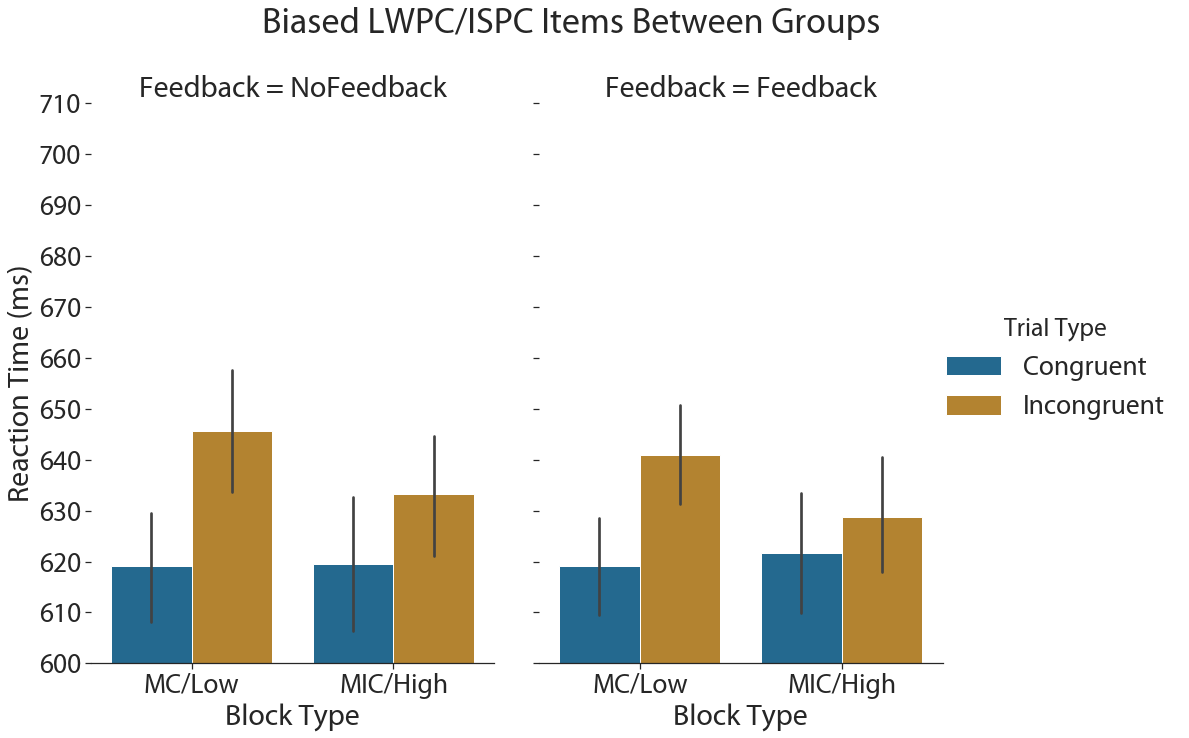

In [20]:
mybargraph("BlockType","RT","Congruency","Feedback",["MC/Low", "MIC/High"],RTmeans,"Block Type","Reaction Time (ms)","Biased LWPC/ISPC Items Between Groups","Trial Type",600,710,"LWPC_RT_maintask.png",10)

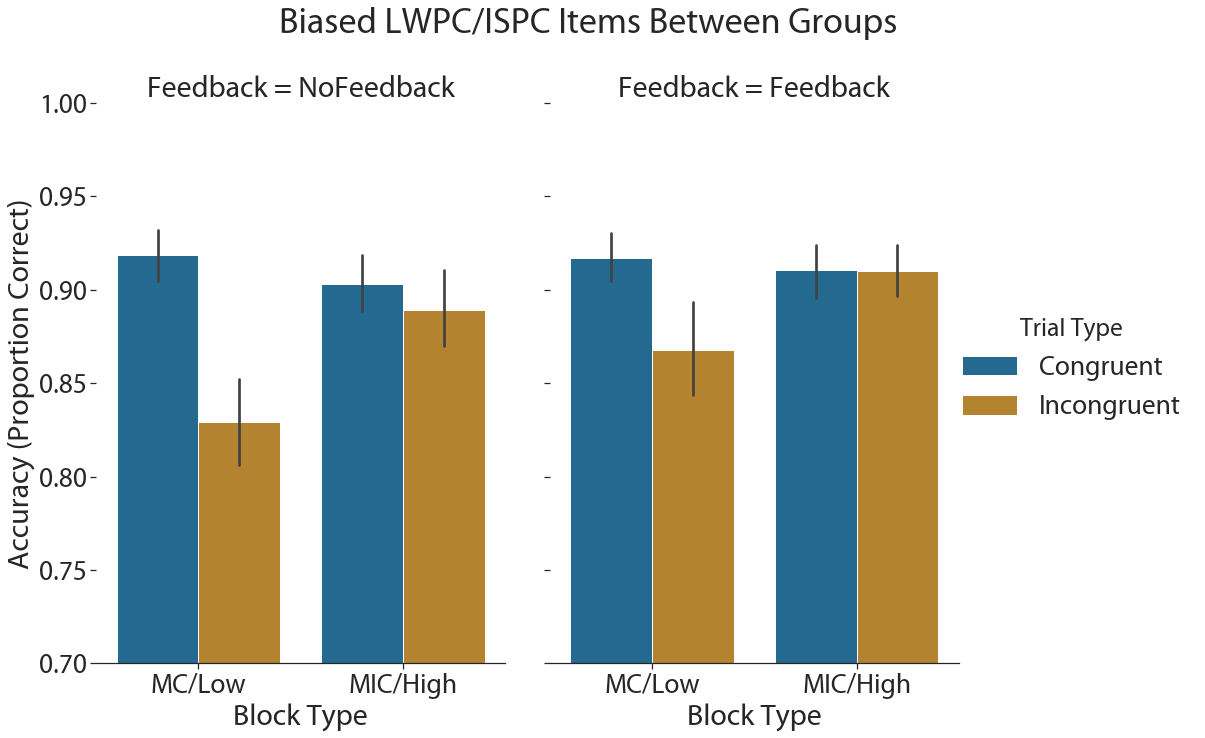

In [21]:
mybargraph("BlockType","Accuracy","Congruency","Feedback",["MC/Low", "MIC/High"],ACCmeans,"Block Type","Accuracy (Proportion Correct)","Biased LWPC/ISPC Items Between Groups","Trial Type",0.7,1.0,"LWPC_ACC_maintask.png",0.05)

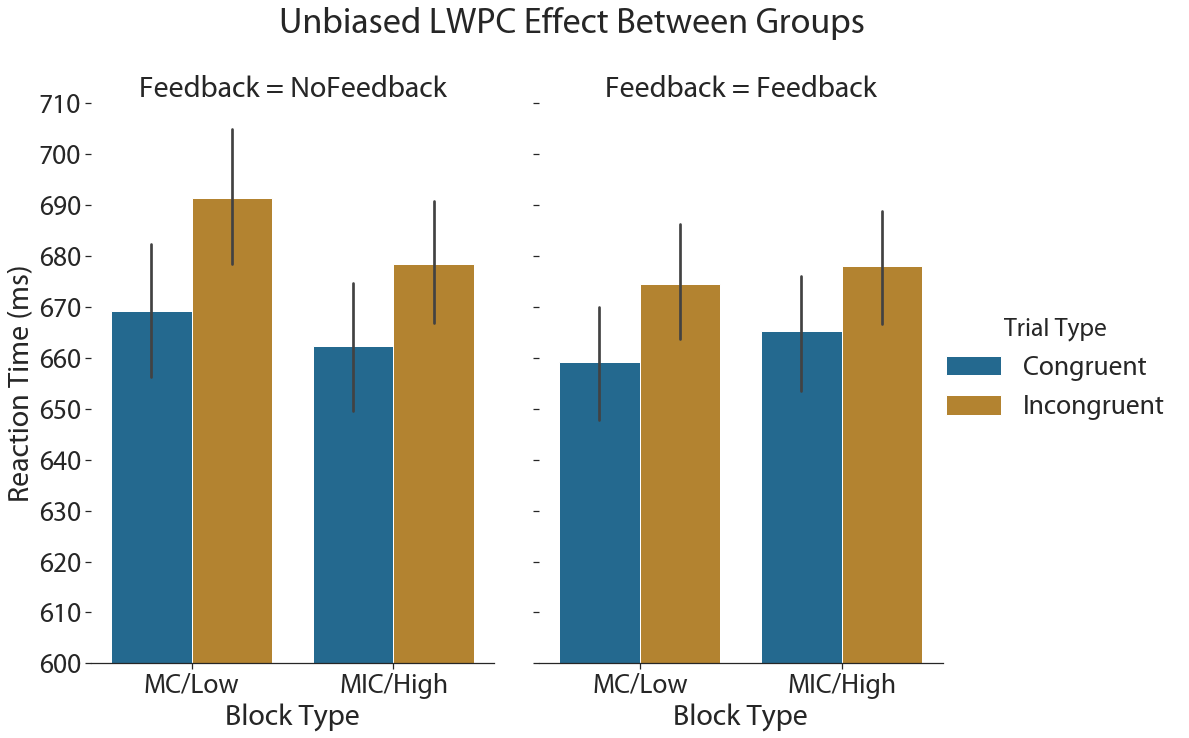

In [22]:
mybargraph("BlockType","RT","Congruency","Feedback",["MC/Low", "MIC/High"],RTmeans_PC50,"Block Type","Reaction Time (ms)","Unbiased LWPC Effect Between Groups","Trial Type",600,710,"LWPC_RT_pc50.png",10)

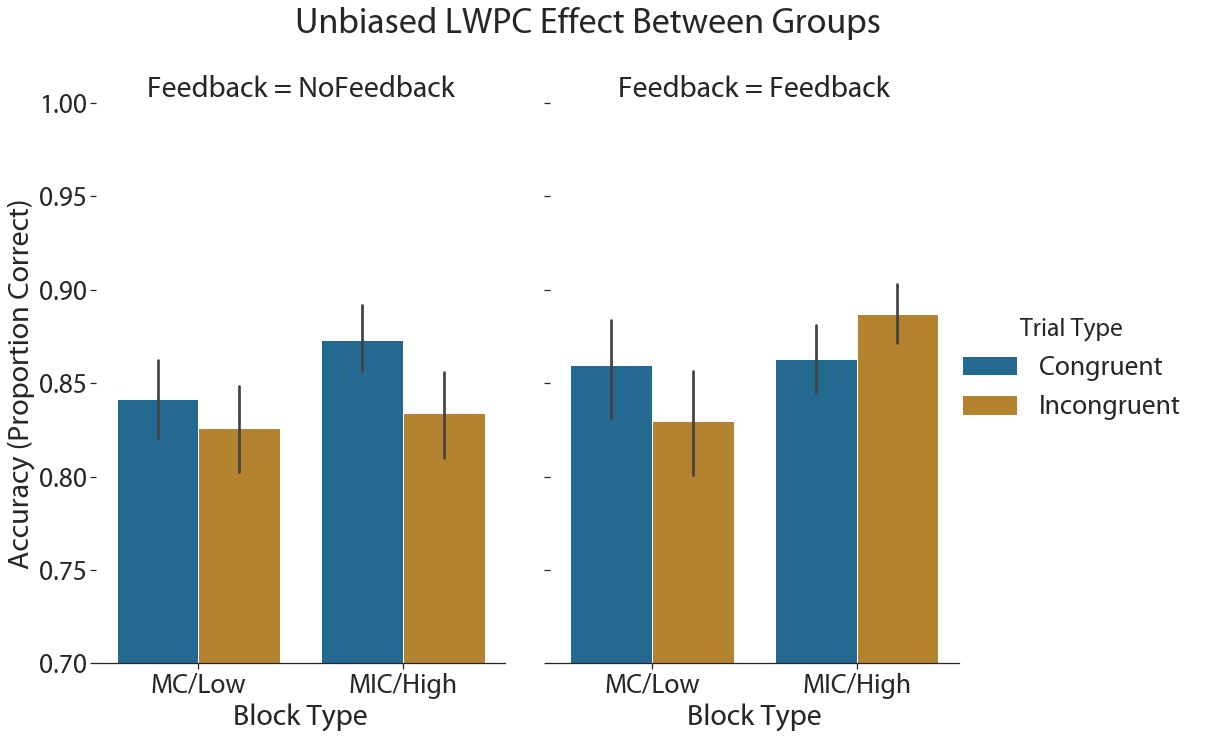

In [23]:
mybargraph("BlockType","Accuracy","Congruency","Feedback",["MC/Low", "MIC/High"],ACCmeans_PC50,"Block Type","Accuracy (Proportion Correct)","Unbiased LWPC Effect Between Groups","Trial Type",0.7,1.0,"LWPC_ACC_pc50.png",0.05)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction
##### also used to calculate inverse efficiency scores, test RT/acc trade-off

In [24]:
FBsubslim = 60;
NoFBsubslim = 30; #subs 1-30 in the list are no fb grp, while 31-60 are fb

In [25]:
#needed to be outside the function because python wasn't recognizing the dfname as an input when dfname = pd.DataFrame()
FB_RT = pd.DataFrame();
NoFB_RT = pd.DataFrame();
FB_ACC = pd.DataFrame();
NoFB_ACC = pd.DataFrame();

In [26]:
def create_wide_df(df,dfname,dv,Group,lim1,lim2):
    lists = [[] for list in range(0,9)]
    data_filter = df[df.Task=='Main'];
    data = data_filter[data_filter.Feedback == Group]
    
    for ID in range(lim1, lim2):
        sub = data[data.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Item != 'PC-50']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Item == 'PC-50']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        lists[1].append(LowC_trials)
        lists[2].append(LowIC_trials)
        lists[3].append(HighC_trials)
        lists[4].append(HighIC_trials)
        lists[5].append(LowC_trials_T)
        lists[6].append(LowIC_trials_T)
        lists[7].append(HighC_trials_T)
        lists[8].append(HighIC_trials_T)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]

In [27]:
create_wide_df(cdat,FB_RT,'RT','Feedback',NoFBsubslim+1,FBsubslim+1);

In [28]:
create_wide_df(cdat,NoFB_RT,'RT','NoFeedback',1,NoFBsubslim+1);

In [29]:
create_wide_df(adat,FB_ACC,'Accuracy','Feedback',(NoFBsubslim+1),(FBsubslim+1));

In [30]:
create_wide_df(adat,NoFB_ACC,'Accuracy','NoFeedback',1,NoFBsubslim+1);

In [31]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [32]:
SC_RT_FB = calc_PCbycong_interaction(FB_RT, 0, 1)

In [33]:
SCT_RT_FB = calc_PCbycong_interaction(FB_RT, 1, 1)

In [34]:
SC_ACC_FB = calc_PCbycong_interaction(FB_ACC, 0, 0)

In [35]:
SCT_ACC_FB = calc_PCbycong_interaction(FB_ACC, 1, 0)

In [36]:
SC_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 0, 1)

In [37]:
SCT_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 1, 1)

In [38]:
SC_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 0, 0)

In [39]:
SCT_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 1, 0)

In [40]:
#interaction effects - both groups
SC_RT = SC_RT_NoFB.append(SC_RT_FB)
SC_ACC = SC_ACC_NoFB.append(SC_ACC_FB)
SCT_RT = SCT_RT_NoFB.append(SCT_RT_FB)
SCT_ACC = SCT_ACC_NoFB.append(SCT_ACC_FB)

In [41]:
def means_overall_group(df, filternum, filter1, filter2, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] != filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 3:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] == filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()
    elif filternum == 4:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] != filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()

        
    X = X.drop('subject',1)
    
    return X

In [42]:
overallRT = means_overall_group(cdat, 0, 0, 0, 'RT')

In [43]:
overallACC = means_overall_group(adat, 0, 0, 0, 'Accuracy')

In [44]:
overallMainRT = means_overall_group(cdat, 2, 'PC-50', 0, 'RT') #main refers to pc-85/15 here

In [45]:
overallMainACC = means_overall_group(adat, 2, 'PC-50', 0, 'Accuracy') #main refers to pc-85/15 here

In [46]:
overallRT_T = means_overall_group(cdat, 1, 'PC-50', 0, 'RT') #_T refers to pc-50 here

In [47]:
overallACC_T = means_overall_group(adat,  1, 'PC-50', 0, 'Accuracy') #_T refers to pc-50 here

In [48]:
MainRT_FB = means_overall_group(cdat, 4, 'PC-50', 'Feedback', 'RT')

In [49]:
MainACC_FB = means_overall_group(adat, 4, 'PC-50', 'Feedback', 'Accuracy')

In [50]:
RT_FB_T = means_overall_group(cdat, 3, 'PC-50', 'Feedback', 'RT')

In [51]:
ACC_FB_T = means_overall_group(adat, 3, 'PC-50', 'Feedback', 'Accuracy')

In [52]:
MainRT_NoFB = means_overall_group(cdat, 4, 'PC-50', 'NoFeedback', 'RT')

In [53]:
MainACC_NoFB = means_overall_group(adat, 4, 'PC-50', 'NoFeedback', 'Accuracy')

In [54]:
RT_NoFB_T = means_overall_group(cdat, 3, 'PC-50', 'NoFeedback', 'RT')

In [55]:
ACC_NoFB_T = means_overall_group(adat, 3, 'PC-50', 'NoFeedback', 'Accuracy')

In [56]:
#checking for a RT/Accuracy trade-off
stats.linregress(overallRT.RT,overallACC.Accuracy)

LinregressResult(slope=-0.0009293826487694347, intercept=1.4610174809919338, rvalue=-0.5964782957693413, pvalue=4.924482713262602e-07, stderr=0.00016421048231666407)

# What about Inverse Efficiency, given the RT/ACC trade-off?

Inverse Efficiency is another metric that shows whether someone is more efficient at responding, not just faster (i.e., it doesn't come with a cost in accuracy).

In [57]:
IE_FB = pd.DataFrame()
IE_NoFB = pd.DataFrame()
IE_all = pd.DataFrame()

IE_FB_T = pd.DataFrame()
IE_NoFB_T = pd.DataFrame()
IE_all_T = pd.DataFrame()

In [58]:
def inverse_efficiency_calc(df1, df2, Group, Transfer, dfname):
    #rt is df1 and proportion correct has to be df2
    lists = [[] for list in range(0,7)]
    
    for ID in range(0,len(df1)):
        sub = df1.SubjectID[ID]
        lists[0].append(sub)
        IE_LowC = df1.LowC[ID] / df2.LowC[ID]
        IE_LowIC = df1.LowIC[ID] / df2.LowIC[ID]
        IE_HighC = df1.HighC[ID] / df2.HighC[ID]
        IE_HighIC = df1.HighIC[ID] / df2.HighIC[ID]
        IE_LowC_T = df1.LowC_T[ID] / df2.LowC_T[ID]
        IE_LowIC_T = df1.LowIC_T[ID] / df2.LowIC_T[ID]
        IE_HighC_T = df1.HighC_T[ID] / df2.HighC_T[ID]
        IE_HighIC_T = df1.HighIC_T[ID] / df2.HighIC_T[ID]
        
        if Transfer == 0:
            lists[1].append(IE_LowC)
            lists[2].append(IE_LowIC)
            lists[3].append(IE_HighC)
            lists[4].append(IE_HighIC)
        elif Transfer == 1:
            lists[1].append(IE_LowC_T)
            lists[2].append(IE_LowIC_T)
            lists[3].append(IE_HighC_T)
            lists[4].append(IE_HighIC_T)
        
        lists[5].append(Group)
        
        if ID < 15:
            lists[6].append("IncongFirst")
        elif ID in range(15,30):
            lists[6].append("CongFirst")
        elif ID in range(30,45):
            lists[6].append("IncongFirst")
        elif ID in range(45,60):
            lists[6].append("CongFirst")
    
    dfname['SubjectID'] = lists[0]
    dfname['C1_1'] = lists[1]
    dfname['C1_2'] = lists[2]
    dfname['C2_1'] = lists[3]
    dfname['C2_2'] = lists[4]
    dfname['Feedback'] = lists[5]
    dfname['BlockOrder'] = lists[6]

In [59]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 0, IE_FB)

In [60]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 0, IE_NoFB)

In [61]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 1, IE_FB_T)

In [62]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 1, IE_NoFB_T)

In [63]:
IE_all = IE_NoFB.append(IE_FB)
IE_all_T = IE_NoFB_T.append(IE_FB_T)

In [64]:
def change_to_longform(df):
    X = pd.wide_to_long(df,['C1', 'C2'],i=["SubjectID","Feedback", "BlockOrder"],j="Congruency",sep='_',suffix='\w')
    X = X.reset_index()
    X = pd.wide_to_long(X,['C'],i=["SubjectID","Feedback", "BlockOrder", "Congruency"],j="DemandCue")
    X = X.reset_index()
    X.columns = ['SubjectID', 'Feedback', 'BlockOrder', 'Congruency', 'DemandCue', 'IE'];
    return X

In [65]:
IE_all = change_to_longform(IE_all)

In [66]:
IE_all_T = change_to_longform(IE_all_T)

In [67]:
#wide_to_long wasn't working if there were strings involved, so I used numbers for the levels and I'm renaming here
dflist = [IE_all, IE_all_T]

for df in dflist:
    df['TrialType'] = df['Congruency'].isin([1,2])
    df.loc[df['Congruency'].isin([1]),'TrialType'] = 'Congruent'
    df.loc[df['Congruency'].isin([2]),'TrialType'] = 'Incongruent'
    
    df['CueType'] = df['DemandCue'].isin([1,2])
    df.loc[df['DemandCue'].isin([1]),'CueType'] = 'Low'
    df.loc[df['DemandCue'].isin([2]),'CueType'] = 'High'

In [68]:
IE_all.to_csv(csvpath+'IE_Main.csv');
IE_all_T.to_csv(csvpath+'IE_transfer.csv');

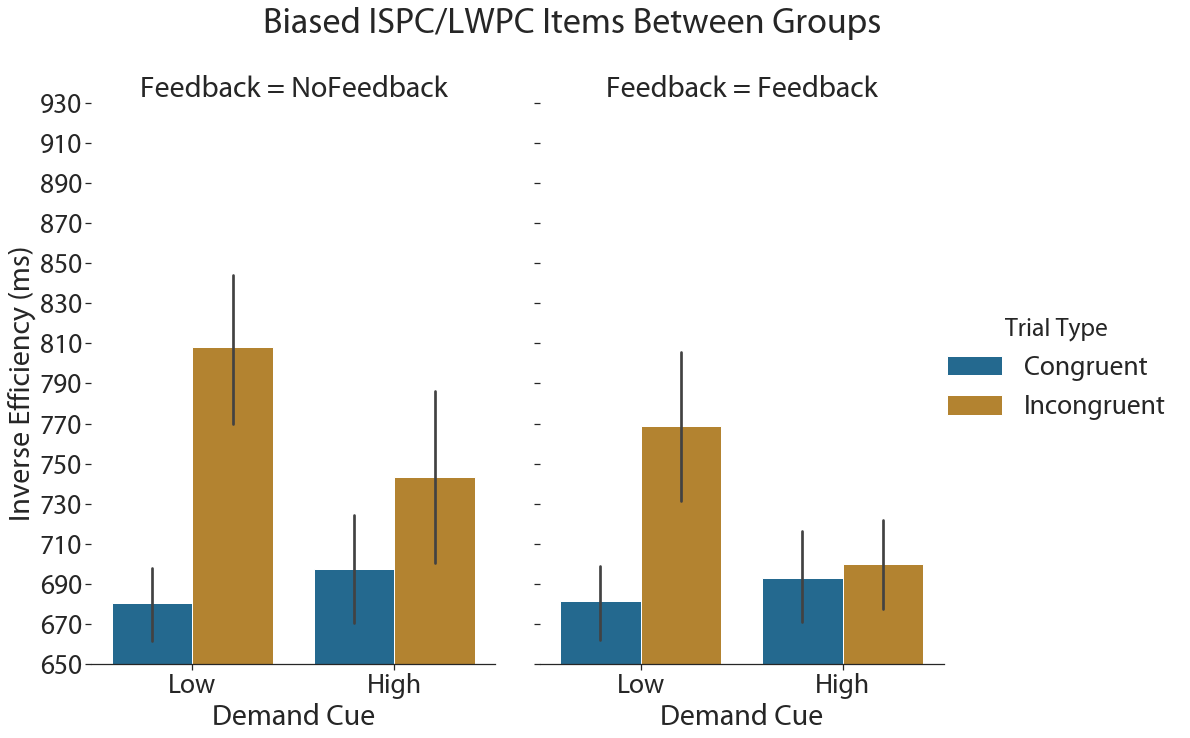

In [69]:
mybargraph("CueType","IE","TrialType","Feedback",["Low", "High"],IE_all,"Demand Cue","Inverse Efficiency (ms)","Biased ISPC/LWPC Items Between Groups","Trial Type",650,930,"LWPC_IE_biased.png",20)

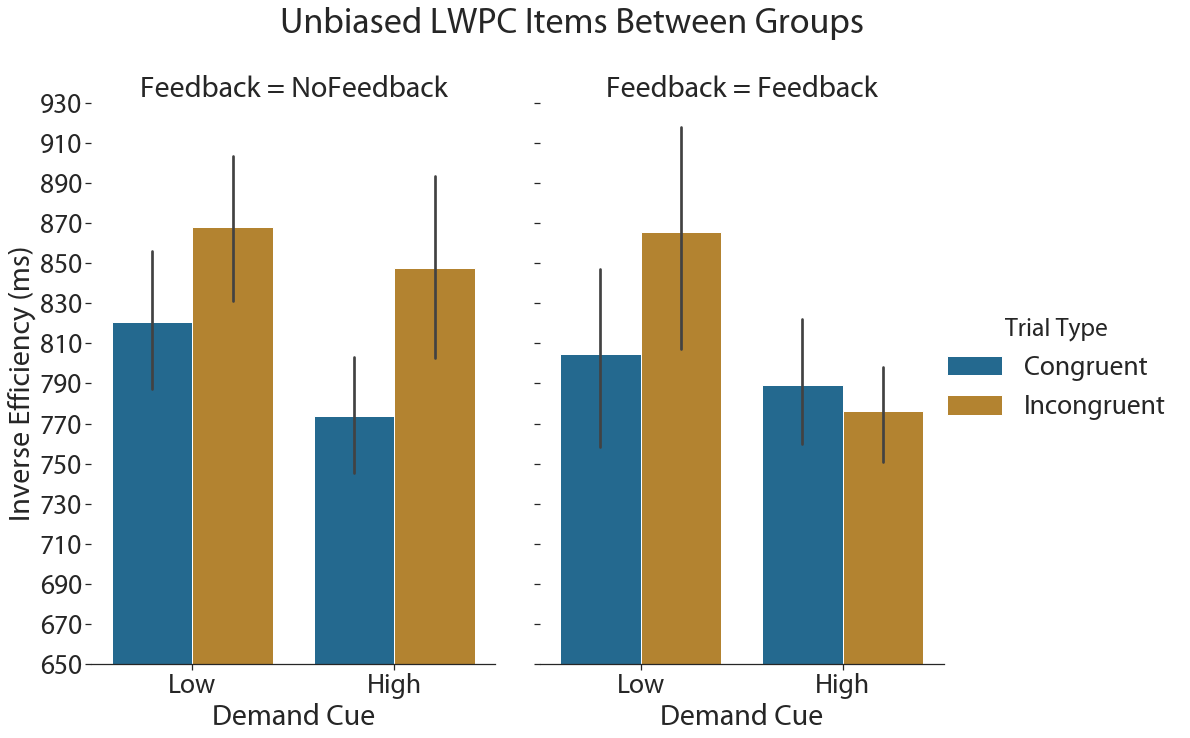

In [70]:
mybargraph("CueType","IE","TrialType","Feedback",["Low", "High"],IE_all_T,"Demand Cue","Inverse Efficiency (ms)","Unbiased LWPC Items Between Groups","Trial Type",650,930,"LWPC_IE_unbiased.png",20)

In [71]:
%%writefile IE_Anova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawRTData <- read.csv('IE_Main.csv')

rawRTData$SubjectID = as.factor(rawRTData$SubjectID)
rawRTData$CueType = as.factor(rawRTData$CueType)
rawRTData$TrialType = as.factor(rawRTData$TrialType)
rawRTData$Feedback = as.factor(rawRTData$Feedback)
rawRTData$BlockOrder = as.factor(rawRTData$BlockOrder)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawRTData_T <- read.csv('IE_transfer.csv')

rawRTData_T$SubjectID = as.factor(rawRTData_T$SubjectID)
rawRTData_T$CueType = as.factor(rawRTData_T$CueType)
rawRTData_T$TrialType = as.factor(rawRTData_T$TrialType)
rawRTData_T$Feedback = as.factor(rawRTData_T$Feedback)
rawRTData_T$BlockOrder = as.factor(rawRTData_T$BlockOrder)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData_T),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

Overwriting IE_Anova.R


In [72]:
! Rscript IE_Anova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\chbejjani\AppData\Local\Temp\Rtmp04OEOx\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\chbejjani\AppData\Local\Temp\Rtmp04OEOx\downloaded_packages
$ANOVA
                                  Effect DFn DFd          SSn       SSd
1                            (Intercept)   1  56 1.249418e+08 4149815.4
2                               Feedback   1  56 2.832977e+04 4149815.4
3                             BlockOrder   1  56 3.177399e+04 4149815.4
5                                CueType   1  56 4.162725e+04 1009239.2
9                              TrialType   1  56 2.685203e+05  463955.8
4                    Feedback:BlockOrder   1  56 6.266107e+03 4149815.4
6                       Feedback:CueType   1  56 3.385627e+02 1009239.2
7                     BlockOrder:CueType   1  56 1.487145e+05 1009239.2
10          

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5906851 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 331810 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


There are several things to observe:

* for *unbiased* items, there is an interaction between Feedback Group x Cue Type x Trial Type. The only other effects are the main effect of Trial Type (Congruency) and interaction of Block Order on Cue Type (expected if back-to-back contexts: e.g., participants will get quicker to respond on the second block of the same context).

* for *biased* items, there is a Block Order x Cue Type x Trial Type & Cue Type x Trial Type interaction, the latter of which is qualified by the higher-order interaction. The other effects are also the main effect of Trial Type & interaction of Block Order on Cue Type, as with unbiased items.

This is showing that, as reflected in the graph, there is a smaller inverse efficiency interaction effect for cue type x trial type for the Feedback Group than the No Feedback Group *for unbiased LWPC items*.

And for *biased ISPC/LWPC items*, the effect of cue x trial type (i.e., standard ISPC effect) is larger for folks who do MC-MC-MIC-MIC vs. MIC-MIC-MC-MC.

### Is there a correlation between the biased and unbiased effects?

In Gonthier et al. (2016), the claim is made that the ISPC reflects reactive control and the LWPC reflects proactive control, so the difference in congruency for items that are biased at the list & item level *should not* relate to the difference in congruency for items that are only biased at the list level.

Here, note that we have a small sample, but we can check if the correlation is nill or negative, as to be predicted.

In [73]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue):
    sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=2, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y.reset_index(drop=True)/corryvalue
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

for the feedback group...?

(LinregressResult(slope=-0.10434205804977185, intercept=3.998846832370733, rvalue=-0.15662013009576814, pvalue=0.40851402042216867, stderr=0.12434828251786922),
 LinregressResult(slope=-0.12935133856874448, intercept=0.006859997935922324, rvalue=-0.21548658728911904, pvalue=0.2527831755248198, stderr=0.11077632169225937))

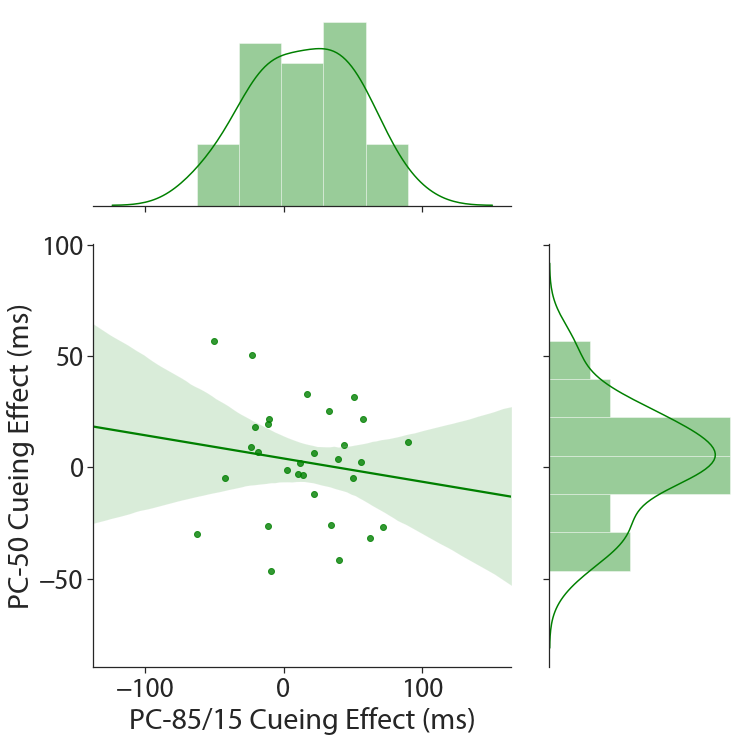

In [74]:
my_corr_graphs(SC_RT_FB.RTs, SCT_RT_FB.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_FB.png", 1, MainRT_FB.RT, RT_FB_T.RT)

for the no feedback group...?

(LinregressResult(slope=-0.09897480479944012, intercept=7.251306802784248, rvalue=-0.14317415347911272, pvalue=0.4503829376205024, stderr=0.1292955244045944),
 LinregressResult(slope=-0.0900622108181527, intercept=0.01031211864760819, rvalue=-0.14422710129794492, pvalue=0.44702368500219924, stderr=0.11677559593720838))

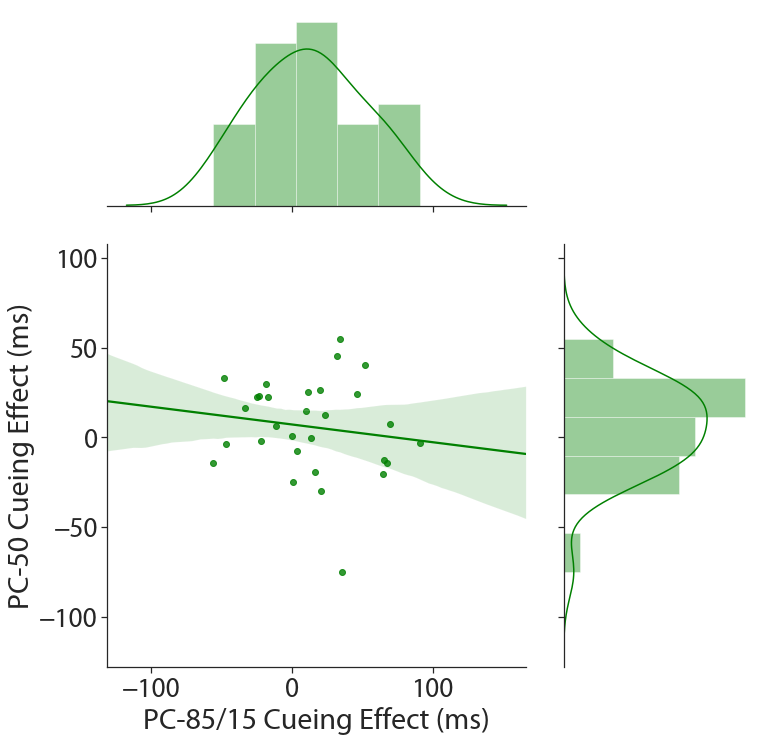

In [75]:
my_corr_graphs(SC_RT_NoFB.RTs, SCT_RT_NoFB.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_NoFB.png", 1, MainRT_NoFB.RT, RT_NoFB_T.RT)

across all subjects...?

(LinregressResult(slope=-0.10286680001633519, intercept=5.638802149930626, rvalue=-0.15118270796248345, pvalue=0.24888409579973353, stderr=0.08831578855404199),
 LinregressResult(slope=-0.11147715230501797, intercept=0.008580650258615062, rvalue=-0.18183942700160677, pvalue=0.16437224492779298, stderr=0.07915572404418392))

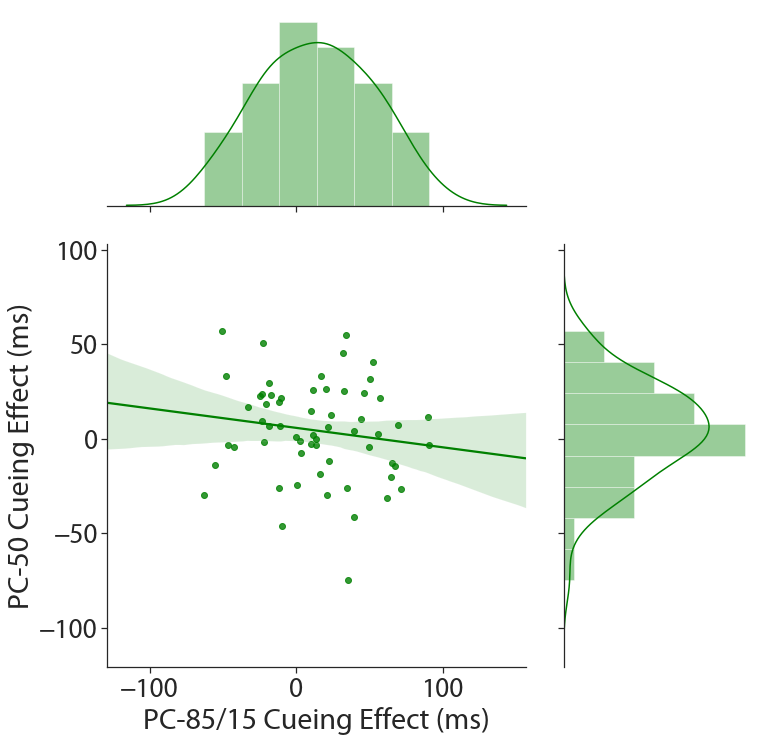

In [76]:
my_corr_graphs(SC_RT.RTs, SCT_RT.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All.png", 0, overallMainRT.RT, overallRT_T.RT)

So, as established in Gonthier et al (2016), the two interaction effects don't really correspond to each other, and if anything, would be negatively correlated.

#### What about for accuracy?

(LinregressResult(slope=0.14865537409867596, intercept=-0.04667961357938841, rvalue=0.18165826530265364, pvalue=0.33668770541060733, stderr=0.1520756686048892),
 LinregressResult(slope=0.14126288504526424, intercept=-0.06100062591868937, rvalue=0.1751388178477883, pvalue=0.35460378044042684, stderr=0.15007268798762302))

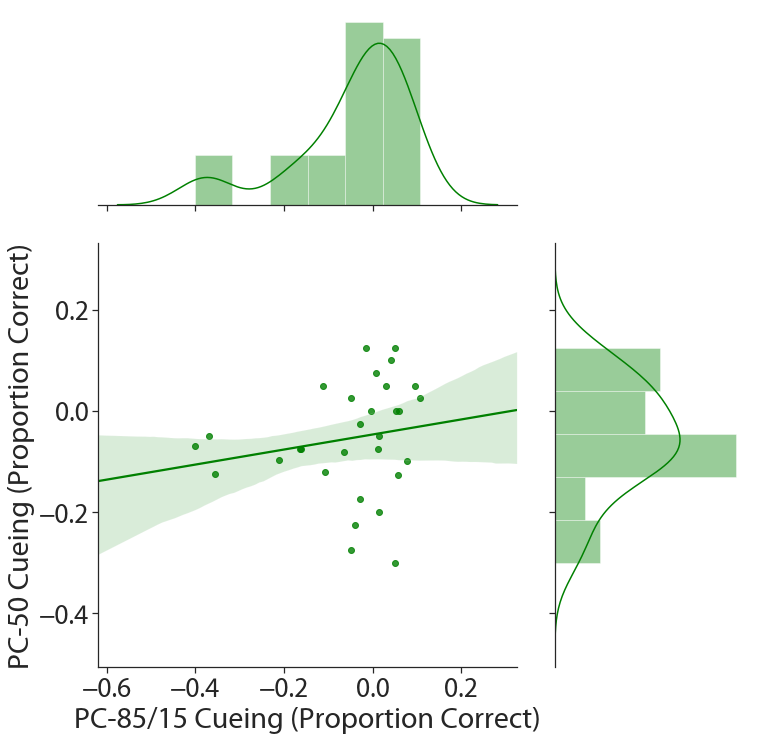

In [77]:
my_corr_graphs(SC_ACC_FB.ACC, SCT_ACC_FB.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_FB_ACC.png", 1, MainACC_FB.Accuracy, ACC_FB_T.Accuracy)

(LinregressResult(slope=0.38630361995219725, intercept=0.05248901374071032, rvalue=0.36160721235410226, pvalue=0.0495923933823564, stderr=0.18822728832116328),
 LinregressResult(slope=0.4477375956652477, intercept=0.06692631252921824, rvalue=0.4189383487821481, pvalue=0.021207777973797772, stderr=0.18339491955293843))

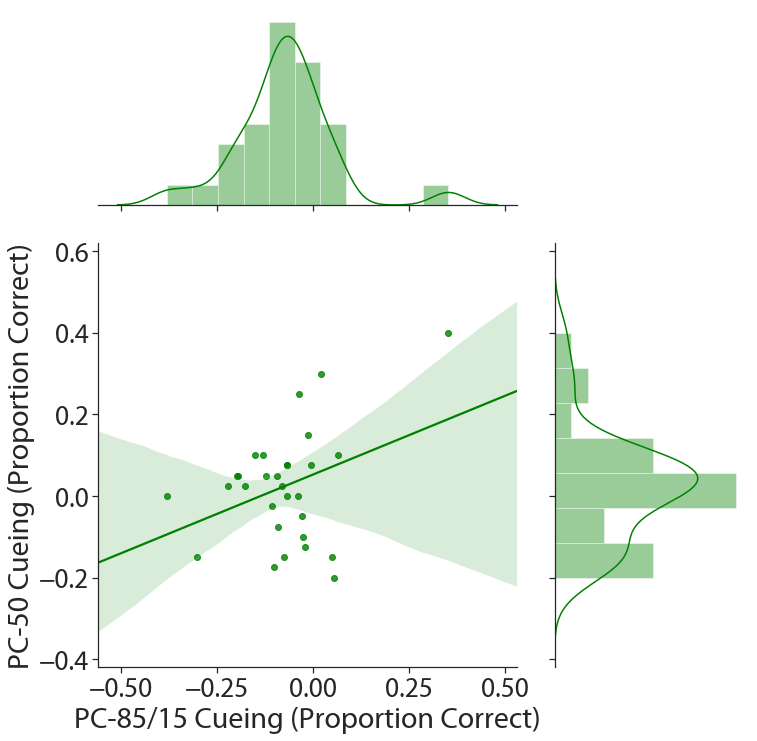

In [78]:
my_corr_graphs(SC_ACC_NoFB.ACC, SCT_ACC_NoFB.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_NoFB_ACC.png", 1, MainACC_NoFB.Accuracy, ACC_NoFB_T.Accuracy)

(LinregressResult(slope=0.22960015553836124, intercept=-0.0010104891435343422, rvalue=0.23274139652188877, pvalue=0.07352681800398563, stderr=0.12597704552721375),
 LinregressResult(slope=0.2641492511722505, intercept=-0.0012346975977105927, rvalue=0.2667016927117485, pvalue=0.03941020805825404, stderr=0.1253392615505228))

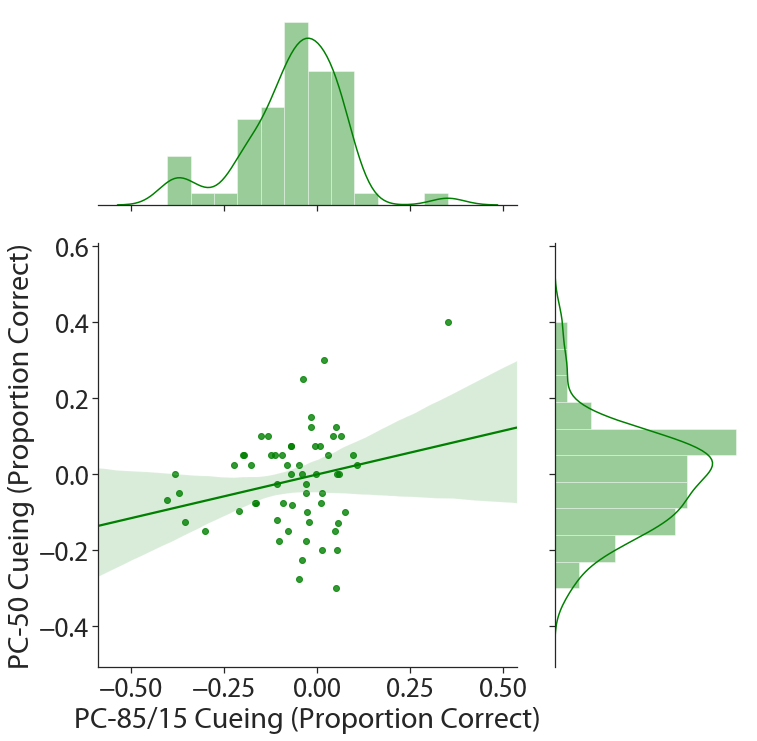

In [79]:
my_corr_graphs(SC_ACC.ACC, SCT_ACC.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_All_ACC.png", 0, overallMainACC.Accuracy, overallACC_T.Accuracy)

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [80]:
import scipy.stats
from pandas.plotting import table

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, acc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if acc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif acc == 1: #can't fully round proportion correct, else it goes to 1.0!
        mrounded = np.round(m,decimals=2); lowerci = np.round(m-h,decimals=2); upperci = np.round(m+h, decimals=0)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [81]:
def ci_effects(df, dv, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 3:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
    elif Context == 4:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
        
    return sub_means

First, let's look at the No Feedback Group for the PC-85/15 items

In [82]:
x = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 2); #2 is Pc-85/15
overallNoFB_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'].RT,0)
overallNoFB_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'].RT,0)
overallNoFB_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'].RT,0)
overallNoFB_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'].RT,0)

In [83]:
x1 = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 4); #4 is Pc-85/15, including RunCounter
r1NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1].RT,0)
r1NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1].RT,0)
r1NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1].RT,0)
r1NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1].RT,0)

r2NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2].RT,0)
r2NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2].RT,0)
r2NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2].RT,0)
r2NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2].RT,0)

r3NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3].RT,0)
r3NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3].RT,0)
r3NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3].RT,0)
r3NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3].RT,0)

r4NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 4].RT,0)
r4NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 4].RT,0)
r4NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 4].RT,0)
r4NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 4].RT,0)

In [84]:
NoFBTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1NoFB_MC_C, r1NoFB_MC_IC, r1NoFB_MIC_C, r1NoFB_MIC_IC],
                     'Run 2': [r2NoFB_MC_C, r2NoFB_MC_IC, r2NoFB_MIC_C, r2NoFB_MIC_IC],
                     'Run 3': [r3NoFB_MC_C, r3NoFB_MC_IC, r3NoFB_MIC_C, r3NoFB_MIC_IC],
                     'Run 4': [r4NoFB_MC_C, r4NoFB_MC_IC, r4NoFB_MIC_C, r4NoFB_MIC_IC],
                     'Overall': [overallNoFB_MC_C, overallNoFB_MC_IC, overallNoFB_MIC_C, overallNoFB_MIC_IC]})

NoFBTable.to_csv(csvpath+'NoFBSupplementaryTable1.csv')
NoFBTable

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(630.0, [595.0, 666.0])","(618.0, [587.0, 648.0])","(610.0, [570.0, 650.0])","(620.0, [584.0, 657.0])","(619.0, [596.0, 643.0])"
1,MC.IC,"(666.0, [616.0, 716.0])","(643.0, [597.0, 688.0])","(632.0, [596.0, 669.0])","(643.0, [612.0, 673.0])","(646.0, [620.0, 671.0])"
2,MIC.C,"(638.0, [587.0, 690.0])","(613.0, [568.0, 658.0])","(613.0, [577.0, 649.0])","(615.0, [584.0, 647.0])","(620.0, [593.0, 646.0])"
3,MIC.IC,"(652.0, [608.0, 695.0])","(628.0, [584.0, 673.0])","(623.0, [592.0, 654.0])","(629.0, [595.0, 662.0])","(633.0, [608.0, 659.0])"


And now what about the feedback group for the biased items via RT?

In [85]:
x2 = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 2); #2 is Pc-85/15
overallFB_MIC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighIC'].RT,0)
overallFB_MIC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighC'].RT,0)
overallFB_MC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowIC'].RT,0)
overallFB_MC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowC'].RT,0)

In [86]:
x3 = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 4); #4 is Pc-85/15, including RunCounter
r1FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 1].RT,0)
r1FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 1].RT,0)
r1FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 1].RT,0)
r1FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 1].RT,0)

r2FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 2].RT,0)
r2FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 2].RT,0)
r2FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 2].RT,0)
r2FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 2].RT,0)

r3FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 3].RT,0)
r3FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 3].RT,0)
r3FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 3].RT,0)
r3FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 3].RT,0)

r4FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 4].RT,0)
r4FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 4].RT,0)
r4FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 4].RT,0)
r4FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 4].RT,0)

In [87]:
FBTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1FB_MC_C, r1FB_MC_IC, r1FB_MIC_C, r1FB_MIC_IC],
                     'Run 2': [r2FB_MC_C, r2FB_MC_IC, r2FB_MIC_C, r2FB_MIC_IC],
                     'Run 3': [r3FB_MC_C, r3FB_MC_IC, r3FB_MIC_C, r3FB_MIC_IC],
                     'Run 4': [r4FB_MC_C, r4FB_MC_IC, r4FB_MIC_C, r4FB_MIC_IC],
                     'Overall': [overallFB_MC_C, overallFB_MC_IC, overallFB_MIC_C, overallFB_MIC_IC]})

FBTable.to_csv(csvpath+'FBSupplementaryTable2.csv')
FBTable

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(632.0, [604.0, 659.0])","(618.0, [588.0, 649.0])","(609.0, [573.0, 644.0])","(619.0, [582.0, 656.0])","(619.0, [598.0, 640.0])"
1,MC.IC,"(654.0, [621.0, 687.0])","(651.0, [620.0, 681.0])","(630.0, [596.0, 664.0])","(635.0, [600.0, 670.0])","(641.0, [621.0, 661.0])"
2,MIC.C,"(609.0, [570.0, 648.0])","(615.0, [577.0, 652.0])","(636.0, [600.0, 671.0])","(626.0, [586.0, 665.0])","(622.0, [598.0, 645.0])"
3,MIC.IC,"(632.0, [596.0, 668.0])","(629.0, [594.0, 665.0])","(632.0, [597.0, 668.0])","(622.0, [585.0, 660.0])","(629.0, [606.0, 652.0])"


And for Accuracy, first for no feedback group, with biased items...

In [88]:
x4 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 2); #2 is Pc-85/15
overallNoFB_MIC_IC_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'HighIC'].Accuracy,1)
overallNoFB_MIC_C_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'HighC'].Accuracy,1)
overallNoFB_MC_IC_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'LowIC'].Accuracy,1)
overallNoFB_MC_C_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'LowC'].Accuracy,1)

In [89]:
x5 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 4); #4 is Pc-85/15, including RunCounter
r1NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 1].Accuracy,1)
r1NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 1].Accuracy,1)
r1NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 1].Accuracy,1)
r1NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 1].Accuracy,1)

r2NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 2].Accuracy,1)
r2NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 2].Accuracy,1)
r2NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 2].Accuracy,1)
r2NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 2].Accuracy,1)

r3NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 3].Accuracy,1)
r3NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 3].Accuracy,1)
r3NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 3].Accuracy,1)
r3NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 3].Accuracy,1)

r4NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 4].Accuracy,1)
r4NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 4].Accuracy,1)
r4NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 4].Accuracy,1)
r4NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 4].Accuracy,1)

In [90]:
NoFBTable_ACC = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1NoFB_MC_C_ACC, r1NoFB_MC_IC_ACC, r1NoFB_MIC_C_ACC, r1NoFB_MIC_IC_ACC],
                     'Run 2': [r2NoFB_MC_C_ACC, r2NoFB_MC_IC_ACC, r2NoFB_MIC_C_ACC, r2NoFB_MIC_IC_ACC],
                     'Run 3': [r3NoFB_MC_C_ACC, r3NoFB_MC_IC_ACC, r3NoFB_MIC_C_ACC, r3NoFB_MIC_IC_ACC],
                     'Run 4': [r4NoFB_MC_C_ACC, r4NoFB_MC_IC_ACC, r4NoFB_MIC_C_ACC, r4NoFB_MIC_IC_ACC],
                    'Overall': [overallNoFB_MC_C_ACC, overallNoFB_MC_IC_ACC, overallNoFB_MIC_C_ACC, overallNoFB_MIC_IC_ACC]})

NoFBTable_ACC.to_csv(csvpath+'NoFB_ACC_SupplementaryTable3.csv')
NoFBTable_ACC

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.85, [0.78, 1.0])","(0.92, [0.88, 1.0])","(0.96, [0.93, 1.0])","(0.94, [0.91, 1.0])","(0.92, [0.89, 1.0])"
1,MC.IC,"(0.72, [0.6, 1.0])","(0.82, [0.74, 1.0])","(0.92, [0.89, 1.0])","(0.85, [0.79, 1.0])","(0.83, [0.78, 1.0])"
2,MIC.C,"(0.9, [0.82, 1.0])","(0.93, [0.89, 1.0])","(0.9, [0.86, 1.0])","(0.88, [0.82, 1.0])","(0.9, [0.87, 1.0])"
3,MIC.IC,"(0.83, [0.68, 1.0])","(0.93, [0.9, 1.0])","(0.89, [0.86, 1.0])","(0.91, [0.87, 1.0])","(0.89, [0.85, 1.0])"


And now for the feedback group, for accuracy, for biased items...

In [91]:
x6 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 2); #2 is Pc-85/15
overallFB_MIC_IC_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'HighIC'].Accuracy,1)
overallFB_MIC_C_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'HighC'].Accuracy,1)
overallFB_MC_IC_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'LowIC'].Accuracy,1)
overallFB_MC_C_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'LowC'].Accuracy,1)

In [92]:
x7 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 4); #4 is Pc-85/15, including RunCounter
r1FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 1].Accuracy,1)
r1FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 1].Accuracy,1)
r1FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 1].Accuracy,1)
r1FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 1].Accuracy,1)

r2FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 2].Accuracy,1)
r2FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 2].Accuracy,1)
r2FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 2].Accuracy,1)
r2FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 2].Accuracy,1)

r3FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 3].Accuracy,1)
r3FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 3].Accuracy,1)
r3FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 3].Accuracy,1)
r3FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 3].Accuracy,1)

r4FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 4].Accuracy,1)
r4FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 4].Accuracy,1)
r4FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 4].Accuracy,1)
r4FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 4].Accuracy,1)

In [93]:
FBTable_ACC = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1FB_MC_C_ACC, r1FB_MC_IC_ACC, r1FB_MIC_C_ACC, r1FB_MIC_IC_ACC],
                     'Run 2': [r2FB_MC_C_ACC, r2FB_MC_IC_ACC, r2FB_MIC_C_ACC, r2FB_MIC_IC_ACC],
                     'Run 3': [r3FB_MC_C_ACC, r3FB_MC_IC_ACC, r3FB_MIC_C_ACC, r3FB_MIC_IC_ACC],
                     'Run 4': [r4FB_MC_C_ACC, r4FB_MC_IC_ACC, r4FB_MIC_C_ACC, r4FB_MIC_IC_ACC],
                     'Overall': [overallFB_MC_C_ACC, overallFB_MC_IC_ACC, overallFB_MIC_C_ACC, overallFB_MIC_IC_ACC]})

FBTable_ACC.to_csv(csvpath+'FB_ACC_SupplementaryTable4.csv')
FBTable_ACC

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.91, [0.86, 1.0])","(0.93, [0.9, 1.0])","(0.92, [0.88, 1.0])","(0.91, [0.86, 1.0])","(0.92, [0.89, 1.0])"
1,MC.IC,"(0.84, [0.71, 1.0])","(0.85, [0.77, 1.0])","(0.88, [0.8, 1.0])","(0.9, [0.82, 1.0])","(0.87, [0.82, 1.0])"
2,MIC.C,"(0.9, [0.83, 1.0])","(0.92, [0.86, 1.0])","(0.93, [0.89, 1.0])","(0.9, [0.84, 1.0])","(0.91, [0.88, 1.0])"
3,MIC.IC,"(0.91, [0.85, 1.0])","(0.9, [0.85, 1.0])","(0.92, [0.88, 1.0])","(0.92, [0.88, 1.0])","(0.91, [0.88, 1.0])"


#### now for unbiased items

In [94]:
x = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 1); #1 is Pc-50/50
overallNoFB_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'].RT,0)
overallNoFB_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'].RT,0)
overallNoFB_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'].RT,0)
overallNoFB_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'].RT,0)

In [95]:
x1 = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 3); #3 is Pc-50/50, including RunCounter
r1NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1].RT,0)
r1NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1].RT,0)
r1NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1].RT,0)
r1NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1].RT,0)

r2NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2].RT,0)
r2NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2].RT,0)
r2NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2].RT,0)
r2NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2].RT,0)

r3NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3].RT,0)
r3NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3].RT,0)
r3NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3].RT,0)
r3NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3].RT,0)

r4NoFB_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 4].RT,0)
r4NoFB_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 4].RT,0)
r4NoFB_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 4].RT,0)
r4NoFB_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 4].RT,0)

In [96]:
NoFBTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1NoFB_MC_C, r1NoFB_MC_IC, r1NoFB_MIC_C, r1NoFB_MIC_IC],
                     'Run 2': [r2NoFB_MC_C, r2NoFB_MC_IC, r2NoFB_MIC_C, r2NoFB_MIC_IC],
                     'Run 3': [r3NoFB_MC_C, r3NoFB_MC_IC, r3NoFB_MIC_C, r3NoFB_MIC_IC],
                     'Run 4': [r4NoFB_MC_C, r4NoFB_MC_IC, r4NoFB_MIC_C, r4NoFB_MIC_IC],
                     'Overall': [overallNoFB_MC_C, overallNoFB_MC_IC, overallNoFB_MIC_C, overallNoFB_MIC_IC]})

NoFBTable.to_csv(csvpath+'NoFBSupplementaryTable5.csv')
NoFBTable

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(684.0, [636.0, 732.0])","(656.0, [617.0, 694.0])","(672.0, [626.0, 719.0])","(667.0, [626.0, 708.0])","(669.0, [641.0, 697.0])"
1,MC.IC,"(697.0, [654.0, 740.0])","(689.0, [654.0, 723.0])","(692.0, [644.0, 740.0])","(688.0, [641.0, 736.0])","(691.0, [664.0, 719.0])"
2,MIC.C,"(669.0, [622.0, 716.0])","(658.0, [613.0, 704.0])","(671.0, [635.0, 708.0])","(652.0, [614.0, 690.0])","(662.0, [635.0, 689.0])"
3,MIC.IC,"(691.0, [638.0, 744.0])","(679.0, [634.0, 723.0])","(676.0, [646.0, 706.0])","(672.0, [642.0, 702.0])","(678.0, [653.0, 704.0])"


In [97]:
x2 = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 1); #2 is Pc-50/50
overallFB_MIC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighIC'].RT,0)
overallFB_MIC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighC'].RT,0)
overallFB_MC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowIC'].RT,0)
overallFB_MC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowC'].RT,0)

In [98]:
x3 = ci_effects(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 3); #3 is Pc-50/50, including RunCounter
r1FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 1].RT,0)
r1FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 1].RT,0)
r1FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 1].RT,0)
r1FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 1].RT,0)

r2FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 2].RT,0)
r2FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 2].RT,0)
r2FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 2].RT,0)
r2FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 2].RT,0)

r3FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 3].RT,0)
r3FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 3].RT,0)
r3FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 3].RT,0)
r3FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 3].RT,0)

r4FB_MIC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighIC'].loc[x3['RunCounter'] == 4].RT,0)
r4FB_MIC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'HighC'].loc[x3['RunCounter'] == 4].RT,0)
r4FB_MC_IC = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowIC'].loc[x3['RunCounter'] == 4].RT,0)
r4FB_MC_C = mean_confidence_interval(x3.loc[x3['ContextCong'] == 'LowC'].loc[x3['RunCounter'] == 4].RT,0)

In [99]:
FBTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1FB_MC_C, r1FB_MC_IC, r1FB_MIC_C, r1FB_MIC_IC],
                     'Run 2': [r2FB_MC_C, r2FB_MC_IC, r2FB_MIC_C, r2FB_MIC_IC],
                     'Run 3': [r3FB_MC_C, r3FB_MC_IC, r3FB_MIC_C, r3FB_MIC_IC],
                     'Run 4': [r4FB_MC_C, r4FB_MC_IC, r4FB_MIC_C, r4FB_MIC_IC],
                     'Overall': [overallFB_MC_C, overallFB_MC_IC, overallFB_MIC_C, overallFB_MIC_IC]})

FBTable.to_csv(csvpath+'FBSupplementaryTable6.csv')
FBTable

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(671.0, [636.0, 707.0])","(666.0, [635.0, 696.0])","(646.0, [607.0, 686.0])","(655.0, [614.0, 695.0])","(659.0, [636.0, 683.0])"
1,MC.IC,"(697.0, [655.0, 738.0])","(674.0, [639.0, 710.0])","(670.0, [631.0, 708.0])","(660.0, [623.0, 697.0])","(674.0, [651.0, 698.0])"
2,MIC.C,"(670.0, [633.0, 708.0])","(669.0, [633.0, 706.0])","(672.0, [634.0, 710.0])","(653.0, [615.0, 690.0])","(665.0, [642.0, 689.0])"
3,MIC.IC,"(681.0, [644.0, 718.0])","(671.0, [639.0, 703.0])","(691.0, [656.0, 727.0])","(671.0, [633.0, 709.0])","(678.0, [656.0, 701.0])"


In [100]:
x4 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 1); #1 is Pc-50/50
overallNoFB_MIC_IC_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'HighIC'].Accuracy,1)
overallNoFB_MIC_C_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'HighC'].Accuracy,1)
overallNoFB_MC_IC_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'LowIC'].Accuracy,1)
overallNoFB_MC_C_ACC = mean_confidence_interval(x4.loc[x4['ContextCong'] == 'LowC'].Accuracy,1)

In [101]:
x5 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 3); #3 is Pc-50/50, including RunCounter
r1NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 1].Accuracy,1)
r1NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 1].Accuracy,1)
r1NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 1].Accuracy,1)
r1NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 1].Accuracy,1)

r2NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 2].Accuracy,1)
r2NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 2].Accuracy,1)
r2NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 2].Accuracy,1)
r2NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 2].Accuracy,1)

r3NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 3].Accuracy,1)
r3NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 3].Accuracy,1)
r3NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 3].Accuracy,1)
r3NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 3].Accuracy,1)

r4NoFB_MIC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighIC'].loc[x5['RunCounter'] == 4].Accuracy,1)
r4NoFB_MIC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'HighC'].loc[x5['RunCounter'] == 4].Accuracy,1)
r4NoFB_MC_IC_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowIC'].loc[x5['RunCounter'] == 4].Accuracy,1)
r4NoFB_MC_C_ACC = mean_confidence_interval(x5.loc[x5['ContextCong'] == 'LowC'].loc[x5['RunCounter'] == 4].Accuracy,1)

In [102]:
NoFBTable_ACC = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1NoFB_MC_C_ACC, r1NoFB_MC_IC_ACC, r1NoFB_MIC_C_ACC, r1NoFB_MIC_IC_ACC],
                     'Run 2': [r2NoFB_MC_C_ACC, r2NoFB_MC_IC_ACC, r2NoFB_MIC_C_ACC, r2NoFB_MIC_IC_ACC],
                     'Run 3': [r3NoFB_MC_C_ACC, r3NoFB_MC_IC_ACC, r3NoFB_MIC_C_ACC, r3NoFB_MIC_IC_ACC],
                     'Run 4': [r4NoFB_MC_C_ACC, r4NoFB_MC_IC_ACC, r4NoFB_MIC_C_ACC, r4NoFB_MIC_IC_ACC],
                    'Overall': [overallNoFB_MC_C_ACC, overallNoFB_MC_IC_ACC, overallNoFB_MIC_C_ACC, overallNoFB_MIC_IC_ACC]})

NoFBTable_ACC.to_csv(csvpath+'NoFB_ACC_SupplementaryTable7.csv')
NoFBTable_ACC

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.78, [0.66, 1.0])","(0.84, [0.76, 1.0])","(0.89, [0.86, 1.0])","(0.85, [0.77, 1.0])","(0.84, [0.8, 1.0])"
1,MC.IC,"(0.76, [0.63, 1.0])","(0.84, [0.77, 1.0])","(0.85, [0.78, 1.0])","(0.85, [0.78, 1.0])","(0.83, [0.78, 1.0])"
2,MIC.C,"(0.88, [0.79, 1.0])","(0.91, [0.86, 1.0])","(0.85, [0.78, 1.0])","(0.86, [0.81, 1.0])","(0.87, [0.84, 1.0])"
3,MIC.IC,"(0.78, [0.63, 1.0])","(0.87, [0.82, 1.0])","(0.84, [0.77, 1.0])","(0.85, [0.78, 1.0])","(0.83, [0.79, 1.0])"


In [103]:
x6 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 1); #1 is Pc-50/50
overallFB_MIC_IC_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'HighIC'].Accuracy,1)
overallFB_MIC_C_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'HighC'].Accuracy,1)
overallFB_MC_IC_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'LowIC'].Accuracy,1)
overallFB_MC_C_ACC = mean_confidence_interval(x6.loc[x6['ContextCong'] == 'LowC'].Accuracy,1)

In [104]:
x7 = ci_effects(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 3); #3 is Pc-50/50, including RunCounter
r1FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 1].Accuracy,1)
r1FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 1].Accuracy,1)
r1FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 1].Accuracy,1)
r1FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 1].Accuracy,1)

r2FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 2].Accuracy,1)
r2FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 2].Accuracy,1)
r2FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 2].Accuracy,1)
r2FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 2].Accuracy,1)

r3FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 3].Accuracy,1)
r3FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 3].Accuracy,1)
r3FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 3].Accuracy,1)
r3FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 3].Accuracy,1)

r4FB_MIC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighIC'].loc[x7['RunCounter'] == 4].Accuracy,1)
r4FB_MIC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'HighC'].loc[x7['RunCounter'] == 4].Accuracy,1)
r4FB_MC_IC_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowIC'].loc[x7['RunCounter'] == 4].Accuracy,1)
r4FB_MC_C_ACC = mean_confidence_interval(x7.loc[x7['ContextCong'] == 'LowC'].loc[x7['RunCounter'] == 4].Accuracy,1)

In [105]:
FBTable_ACC = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1FB_MC_C_ACC, r1FB_MC_IC_ACC, r1FB_MIC_C_ACC, r1FB_MIC_IC_ACC],
                     'Run 2': [r2FB_MC_C_ACC, r2FB_MC_IC_ACC, r2FB_MIC_C_ACC, r2FB_MIC_IC_ACC],
                     'Run 3': [r3FB_MC_C_ACC, r3FB_MC_IC_ACC, r3FB_MIC_C_ACC, r3FB_MIC_IC_ACC],
                     'Run 4': [r4FB_MC_C_ACC, r4FB_MC_IC_ACC, r4FB_MIC_C_ACC, r4FB_MIC_IC_ACC],
                     'Overall': [overallFB_MC_C_ACC, overallFB_MC_IC_ACC, overallFB_MIC_C_ACC, overallFB_MIC_IC_ACC]})

FBTable_ACC.to_csv(csvpath+'FB_ACC_SupplementaryTable8.csv')
FBTable_ACC

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.84, [0.74, 1.0])","(0.83, [0.74, 1.0])","(0.9, [0.83, 1.0])","(0.86, [0.79, 1.0])","(0.86, [0.81, 1.0])"
1,MC.IC,"(0.77, [0.64, 1.0])","(0.82, [0.74, 1.0])","(0.86, [0.8, 1.0])","(0.87, [0.79, 1.0])","(0.83, [0.77, 1.0])"
2,MIC.C,"(0.88, [0.8, 1.0])","(0.86, [0.77, 1.0])","(0.85, [0.78, 1.0])","(0.87, [0.82, 1.0])","(0.86, [0.82, 1.0])"
3,MIC.IC,"(0.87, [0.8, 1.0])","(0.88, [0.81, 1.0])","(0.92, [0.87, 1.0])","(0.88, [0.83, 1.0])","(0.89, [0.86, 1.0])"


# Post-test Questionnaire Data

This was to assess participant awareness of the task manipulations.

In [106]:
%cd ..

C:\Users\chbejjani\Desktop\LWPCfb\data


In [107]:
posttest = pd.read_csv('posttest.csv')

In [108]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [109]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences at the item and block level.

In [110]:
def mypiegraph(BlockorItem, title, figname):
    fig, ax1 = plt.subplots(figsize=(8, 7));
    if BlockorItem == 0:
        Q1 = [posttest.ItemVary[posttest.ItemVary == 1].count(), posttest.ItemVary[posttest.ItemVary == 0].count()];
    elif BlockorItem == 1:
        Q1 = [posttest.BlockVary[posttest.BlockVary == 1].count(), posttest.BlockVary[posttest.BlockVary == 0].count()];
    Q1labels = ['Yes','No'];
    plt.axis('equal');
    startanglept=90;
    radiussize=0.65;
    legendfontsize=15;
    titlefontsize=17;
    
    patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
    ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
    fig.suptitle(title, fontsize=titlefontsize,fontweight="bold", y = 0.85);
    plb.savefig(figurepath+figname, bbox_inches='tight');

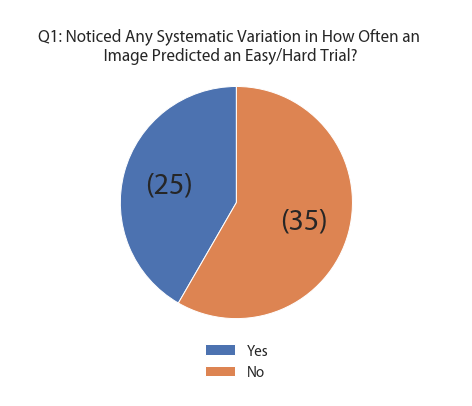

In [111]:
mypiegraph(0, 'Q1: Noticed Any Systematic Variation in How Often an\n Image Predicted an Easy/Hard Trial?', "posttestQ1_Item.png")

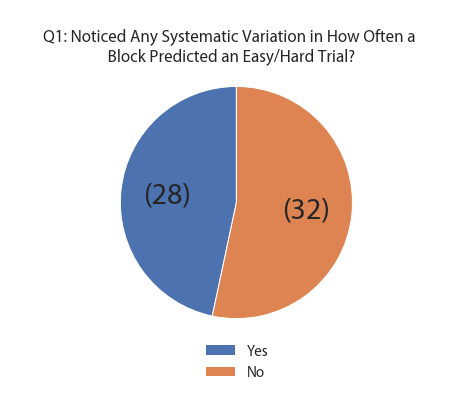

In [112]:
mypiegraph(1, 'Q1: Noticed Any Systematic Variation in How Often a\n Block Predicted an Easy/Hard Trial?', "posttestQ1_Block.png")

#### Next, we asked participants to rate how likely certain images would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were the bear and bird paired together? Bear and deer? Bear and turtle?

Were any of the image category pairings rated as more predictive or nonpredictive than chance (50%)?

In [113]:
stats.ttest_1samp(posttest.FrequencyPredict_1.dropna(),50)

Ttest_1sampResult(statistic=-0.7659790340639526, pvalue=0.44674251656281383)

In [114]:
stats.ttest_1samp(posttest.FrequencyPredict_2.dropna(),50)

Ttest_1sampResult(statistic=-0.25852015458008176, pvalue=0.7969052413854623)

In [115]:
stats.ttest_1samp(posttest.FrequencyPredict_3.dropna(),50)

Ttest_1sampResult(statistic=-1.292493043249508, pvalue=0.20140152274302425)

In [116]:
stats.ttest_1samp(posttest.FrequencyPredict_4.dropna(),50)

Ttest_1sampResult(statistic=-0.9695011054361101, pvalue=0.33632092573710515)

In [117]:
stats.ttest_1samp(posttest.FrequencyPredict_5.dropna(),50)

Ttest_1sampResult(statistic=-0.5650968540498477, pvalue=0.5741872913112358)

Because the image pairs were randomized across participants, we wouldn't expect these to be more predictive than chance. Another way of analyzing this would be to look at for individuals who had bear + bird paired together, did they rate that one category higher? This analysis didn't turn out in the ISPC, and this would require me to hand-code each individual participant's post-test data, so I'm going to skip for now.

In [118]:
GRP_BT = posttest.groupby(['subjID'])['FrequencyPredict_1'].mean() #1 is bear + turtle
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = posttest.groupby(['subjID'])['FrequencyPredict_2'].mean() #2 is bear + bird
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = posttest.groupby(['subjID'])['FrequencyPredict_3'].mean() #3 is bear + deer
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))
GRP_BD2 = posttest.groupby(['subjID'])['FrequencyPredict_4'].mean() #4 is bear + dog
GRP_BD2SEM = pd.Series.std(GRP_BD2.dropna()) / sqrt(len(GRP_BD2.dropna()))
GRP_BC = posttest.groupby(['subjID'])['FrequencyPredict_5'].mean() #5 is bear + cat
GRP_BCSEM = pd.Series.std(GRP_BC.dropna()) / sqrt(len(GRP_BC.dropna()))

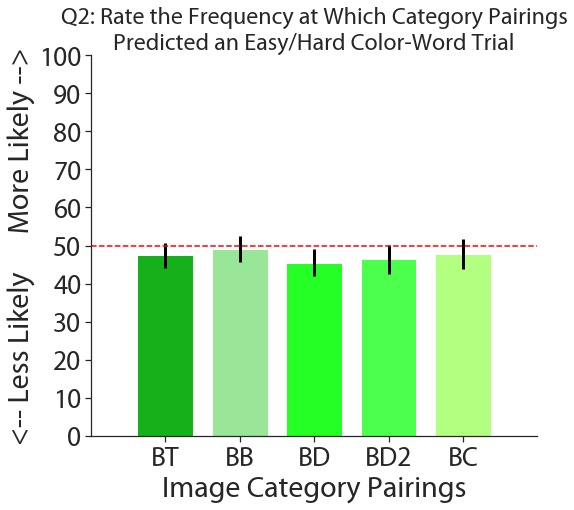

In [119]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(8, 7));
plt.plot([0,1,2,3,4,5,6],[50,50,50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.6,0.9,0.6),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(4,GRP_BD2.dropna().mean(),barwidth,color=(0.3,1,0.3),yerr=GRP_BD2SEM,ecolor='k',error_kw=dict(lw=3));
rects5 = ax.bar(5,GRP_BC.dropna().mean(),barwidth,color=(0.7,1,0.5),yerr=GRP_BCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,6);
ax.set_xticklabels(('BT','BB','BD','BD2','BC'));
ax.set_xticks([1, 2, 3, 4, 5]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which Category Pairings\nPredicted an Easy/Hard Color-Word Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Image Category Pairings',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the images to the Stroop trial type that they most likely preceded. Did they perform better than chance (i.e., 2/6 cue-demand relationships correctly matched)? Unlike in the ISPC, chance here is 2/6 correct because the options were hard/incongruent, easy/congruent, and neutral; we put both the biased and unbiased items together in the SCForcedChoice question.

In [120]:
stats.ttest_1samp(posttest.SCForcedChoice.dropna(),2)

Ttest_1sampResult(statistic=2.3159525823376352, pvalue=0.024054940625410293)

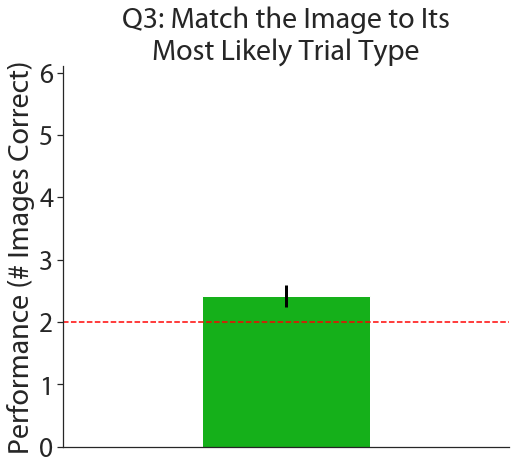

In [121]:
SCFC = posttest.groupby(['subjID'])['SCForcedChoice'].mean();
SCFCSEM = pd.Series.std(SCFC.dropna()) / sqrt(len(SCFC.dropna()));

barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(8, 7));
rects1 = ax.bar(1,SCFC.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=SCFCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,6.1);
ax.set_xlim(0,2);
plt.plot([0,1,2],[2,2,2], 'r--');
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_yticks(np.arange(0, 7, 1));
plt.title('Q3: Match the Image to Its\nMost Likely Trial Type', fontweight="bold");
plt.ylabel('Performance (# Images Correct)', fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ3.png", bbox_inches='tight');

# Exploratory Analysis of the Congruency Sequence Effect

This experiment was primarily designed to look at the effects of performance feedback on the LWPC. Here, this is just me satisfying my curiosity with an exploratory analysis of the CSE.

The CSE is also theorized to be sensitive to reward (Abrahamse et al., 2016). Thus, although the trial design is limited (not all the trial types have equal percentages), we can somewhat assess the effects of FB on the CSE.

In [122]:
rdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1) & (TrialCounter != 1)').copy()
acdat = dat.query('(TrialCounter != 1)').copy()

In [123]:
dataframes = [rdat, acdat];

for df in dataframes:
    df['Feedback'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([9,10]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([3,4]), 'Feedback'] = 'NoFeedback'
    
    df['BlockOrder'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([3,9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([4,10]), 'BlockOrder'] = 'CongFirst'
    
    df['Task'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([0]), 'Task'] = 'Practice'
    df.loc[df['RunCounter'].isin([1,2,3,4]), 'Task'] = 'Main'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'MIC/High'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'MC/Low'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-85'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-15'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['PrevCong'] = df['Prevtrial'].isin([1])
    df.loc[df['Prevtrial'].isin([1]),'PrevCong'] = 'Incongruent'
    df.loc[~df['Prevtrial'].isin([1]),'PrevCong'] = 'Congruent'
    
    df['CSE'] = df['Sequential'].isin([1])
    df.loc[df['Sequential'].isin([1]),'CSE'] = 'Cong-Cong'
    df.loc[df['Sequential'].isin([2]),'CSE'] = 'Incong-Cong'
    df.loc[df['Sequential'].isin([3]),'CSE'] = 'Cong-Incong'
    df.loc[df['Sequential'].isin([4]),'CSE'] = 'Incong-Incong'

Let's take a peak at the means...

In [124]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        617.414144
 Cong-Incong      633.092166
 Incong-Cong      620.804060
 Incong-Incong    633.819928
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.810210
 Cong-Incong      5.677121
 Incong-Cong      5.819821
 Incong-Incong    6.140422
 Name: RT, dtype: float64)

In [125]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        671.750679
 Cong-Incong      684.833311
 Incong-Cong      659.414607
 Incong-Incong    685.490644
 Name: RT, dtype: float64, CSE
 Cong-Cong        6.565055
 Cong-Incong      6.434510
 Incong-Cong      6.728217
 Incong-Incong    6.664035
 Name: RT, dtype: float64)

In [126]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'Feedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        618.668999
 Cong-Incong      631.501240
 Incong-Cong      619.131709
 Incong-Incong    629.312429
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.287267
 Cong-Incong      5.423221
 Incong-Cong      5.315595
 Incong-Incong    5.613241
 Name: RT, dtype: float64)

In [127]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'Feedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        663.300064
 Cong-Incong      672.307305
 Incong-Cong      660.424833
 Incong-Incong    678.418697
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.725346
 Cong-Incong      5.432555
 Incong-Cong      5.599686
 Incong-Incong    5.676212
 Name: RT, dtype: float64)

In [128]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        0.920836
 Cong-Incong      0.863239
 Incong-Cong      0.912017
 Incong-Incong    0.890061
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.006191
 Cong-Incong      0.008805
 Incong-Cong      0.006707
 Incong-Incong    0.010014
 Name: Accuracy, dtype: float64)

In [129]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        0.844626
 Cong-Incong      0.819442
 Incong-Cong      0.869896
 Incong-Incong    0.845685
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.009915
 Cong-Incong      0.011253
 Incong-Cong      0.008376
 Incong-Incong    0.010782
 Name: Accuracy, dtype: float64)

In [130]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        0.923407
 Cong-Incong      0.889838
 Incong-Cong      0.907730
 Incong-Incong    0.915723
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005842
 Cong-Incong      0.008061
 Incong-Cong      0.006982
 Incong-Incong    0.006897
 Name: Accuracy, dtype: float64)

In [131]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        0.860381
 Cong-Incong      0.842820
 Incong-Cong      0.865024
 Incong-Incong    0.880086
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.011620
 Cong-Incong      0.011721
 Incong-Cong      0.009243
 Incong-Incong    0.008581
 Name: Accuracy, dtype: float64)

OK, let's actually analyze the data... Note that there aren't enough trials to analyze PC-50 items. I am also leaving off Block Order because this is just exploratory anyway.

In [132]:
%cd csvdata

C:\Users\chbejjani\Desktop\LWPCfb\data\csvdata


In [133]:
CSE_RT = rdat.loc[rdat['Task'] == 'Main'].loc[rdat['Item'] != 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC = acdat.loc[acdat['Task'] == 'Main'].loc[adat['Item'] != 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

CSE_RT_T = rdat.loc[rdat['Task'] == 'Main'].loc[rdat['Item'] == 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC_T = acdat.loc[acdat['Task'] == 'Main'].loc[acdat['Item'] == 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

#create tidy data csvs
CSE_RT.to_csv(csvpath+'CSE_ANOVA_RT.csv')
CSE_ACC.to_csv(csvpath+'CSE_ANOVA_ACC.csv')
CSE_RT_T.to_csv(csvpath+'CSE_ANOVA_RT_T.csv')
CSE_ACC_T.to_csv(csvpath+'CSE_ANOVA_ACC_T.csv')

In [134]:
%%writefile CSEAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

CSE_RT <- read.csv('CSE_ANOVA_RT.csv')

CSE_RT$subject = as.factor(CSE_RT$subject)
CSE_RT$Feedback = as.factor(CSE_RT$Feedback)
CSE_RT$PrevCong = as.factor(CSE_RT$PrevCong)
CSE_RT$Congruency = as.factor(CSE_RT$Congruency)

CSERT_AN <- ezANOVA(data=as.data.frame(CSE_RT),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSERT_AN)

#

CSE_ACC <- read.csv('CSE_ANOVA_ACC.csv')

CSE_ACC$subject = as.factor(CSE_ACC$subject)
CSE_ACC$Feedback = as.factor(CSE_ACC$Feedback)
CSE_ACC$PrevCong = as.factor(CSE_ACC$PrevCong)
CSE_ACC$Congruency = as.factor(CSE_ACC$Congruency)

CSEACC_AN <- ezANOVA(data=as.data.frame(CSE_ACC),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSEACC_AN)

Overwriting CSEAnova.R


In [135]:
! Rscript CSEAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\chbejjani\AppData\Local\Temp\Rtmp6d4zf4\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\chbejjani\AppData\Local\Temp\Rtmp6d4zf4\downloaded_packages
$ANOVA
                        Effect DFn DFd          SSn       SSd            F
1                  (Intercept)   1  58 9.389048e+07 837753.43 6.500299e+03
2                     Feedback   1  58 1.592146e+02 837753.43 1.102287e-02
3                     PrevCong   1  58 2.144865e+01  10910.79 1.140176e-01
5                   Congruency   1  58 1.002599e+04  23042.04 2.523681e+01
4            Feedback:PrevCong   1  58 1.280616e+02  10910.79 6.807547e-01
6          Feedback:Congruency   1  58 1.210236e+02  23042.04 3.046330e-01
7          PrevCong:Congruency   1  58 1.058817e+02  14628.49 4.198070e-01
8 Feedback:PrevCong:Congruency   1  58 4.240017e-04  14628.4

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5906851 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 331810 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


Let's look at the graphs...

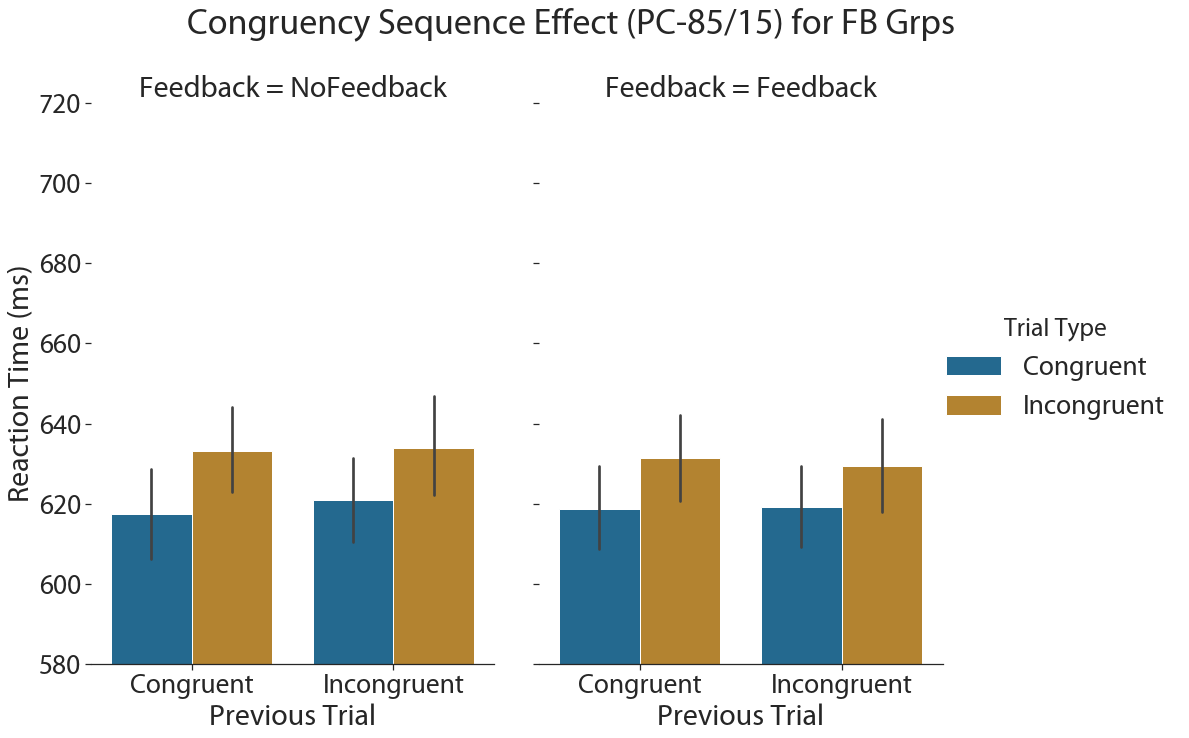

In [136]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect (PC-85/15) for FB Grps","Trial Type",580,720,"CSE_RT.png", 20)

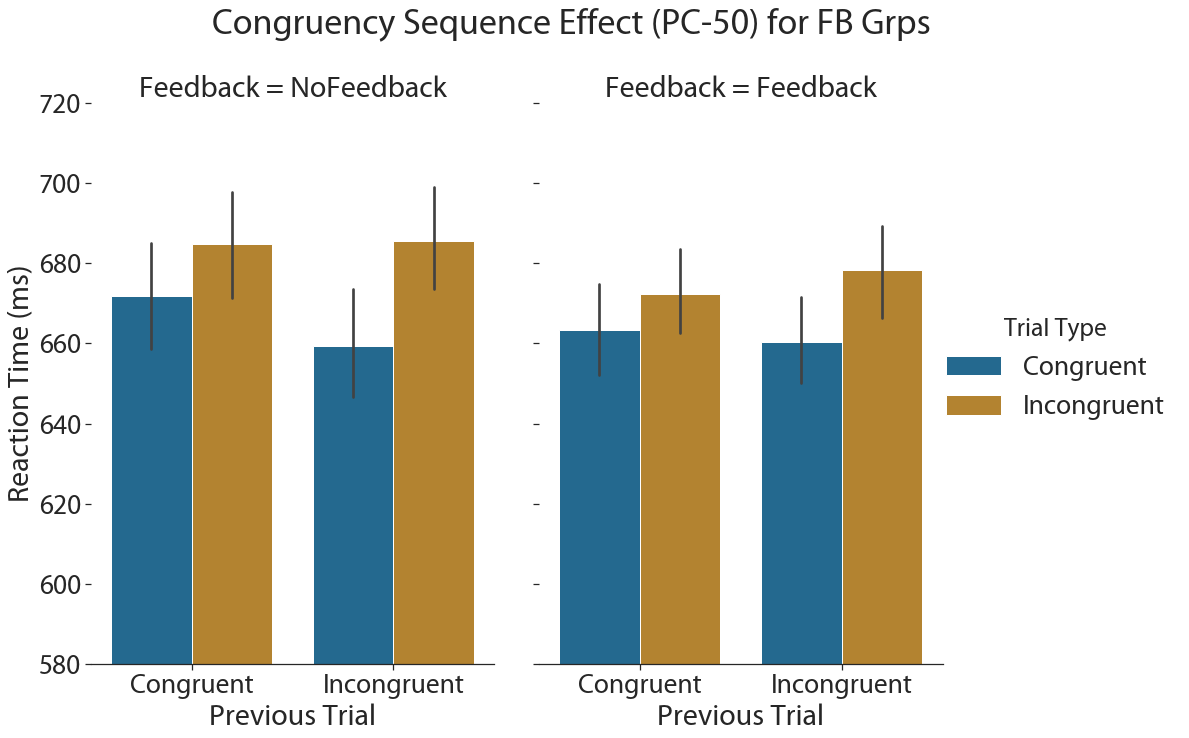

In [137]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT_T,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect (PC-50) for FB Grps","Trial Type",580,720,"CSE_RT_T.png",20)

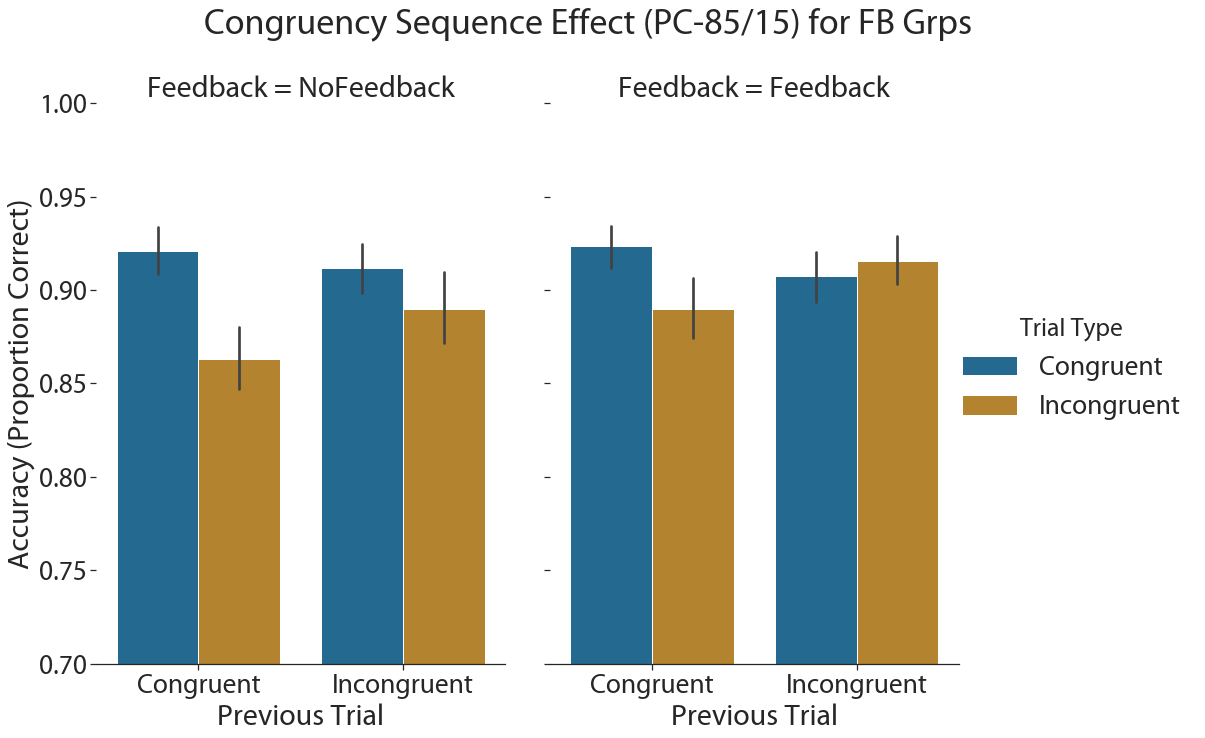

In [138]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect (PC-85/15) for FB Grps","Trial Type",0.7,1.0,"CSE_ACC.png",0.05)

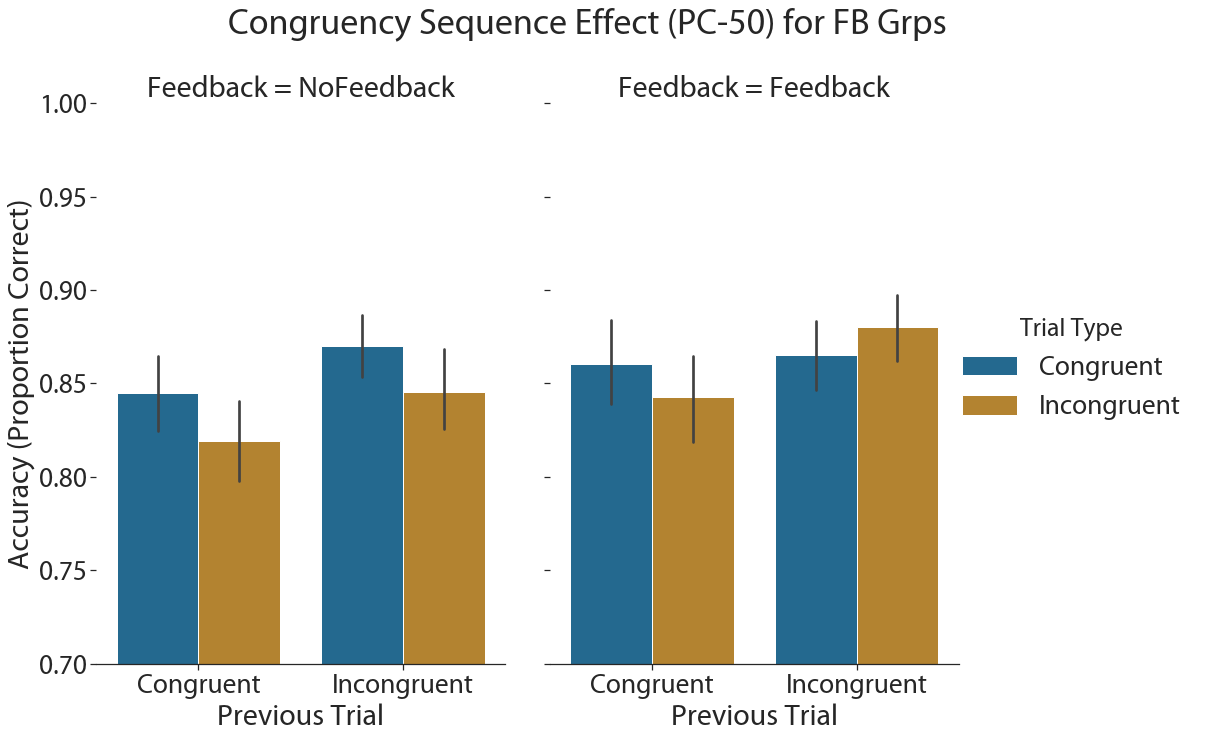

In [139]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC_T,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect (PC-50) for FB Grps","Trial Type",0.7,1.0,"CSE_ACC_T.png",0.05)